In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
client = pd.read_csv('data_berka/client.asc', sep=';')
account = pd.read_csv('data_berka/account.asc', sep=';')
card = pd.read_csv('data_berka/card.asc', sep=';')
disp = pd.read_csv('data_berka/disp.asc', sep=';')
loan = pd.read_csv('data_berka/loan.asc', sep=';')
district = pd.read_csv('data_berka/district.asc', sep=';')
trans = pd.read_csv('data_berka/trans.asc', sep=';', low_memory=False)
order = pd.read_csv('data_berka/order.asc', sep=';')


In [4]:
#Data Cleaning for trans and client Dataset


# Transform the birth day into year
client['birth_year'] = client['birth_number'].transform(lambda bn: int('19' + str(bn)[:2]))
# Age
client['age'] = 1999 - client['birth_year']
# Age group
client['age_group'] = client['age'] 


In [5]:
def to_month_gender(birth_number):
    
    s = str(birth_number)
    birth_month = int(s[2:4])
    
    if birth_month > 50:
        gender = "F"
        birth_month = birth_month - 50
    else:
        gender = 'M'
        
    return pd.Series({'birth_month':birth_month, 'gender':gender})


In [6]:
client[['birth_month', 'gender']] = client['birth_number'].apply(to_month_gender)
client.describe()

client_id   birth_number  district_id   birth_year          age  \
count   5369.000000    5369.000000  5369.000000  5369.000000  5369.000000   
mean    3359.011920  535114.970013    37.310114  1953.198361    45.801639   
std     2832.911984  172895.618429    25.043690    17.282283    17.282283   
min        1.000000  110820.000000     1.000000  1911.000000    12.000000   
25%     1418.000000  406009.000000    14.000000  1940.000000    31.000000   
50%     2839.000000  540829.000000    38.000000  1954.000000    45.000000   
75%     4257.000000  681013.000000    60.000000  1968.000000    59.000000   
max    13998.000000  875927.000000    77.000000  1987.000000    88.000000   

         age_group  birth_month  
count  5369.000000  5369.000000  
mean     45.801639     6.521885  
std      17.282283     3.432381  
min      12.000000     1.000000  
25%      31.000000     4.000000  
50%      45.000000     7.000000  
75%      59.000000     9.000000  
max      88.000000    12.000000

In [7]:
client_acc = pd.merge(client, disp, on='client_id', how='left')
client_loan = pd.merge(client_acc, loan, on='account_id', how='left')
client_loan.head() #Merged table of client,disp and loan.


client_id  birth_number  district_id  birth_year  age  age_group  \
0          1        706213           18        1970   29         29   
1          2        450204            1        1945   54         54   
2          3        406009            1        1940   59         59   
3          4        561201            5        1956   43         43   
4          5        605703            5        1960   39         39   

   birth_month gender  disp_id  account_id       type  loan_id      date  \
0           12      F        1           1      OWNER      NaN       NaN   
1            2      M        2           2      OWNER   4959.0  940105.0   
2           10      F        3           2  DISPONENT   4959.0  940105.0   
3           12      M        4           3      OWNER      NaN       NaN   
4            7      F        5           3  DISPONENT      NaN       NaN   

    amount  duration  payments status  
0      NaN       NaN       NaN    NaN  
1  80952.0      24.0    3373.0      A  
2  80952.0      24.0    3373.0      A  
3      NaN       NaN       NaN    NaN  
4      NaN       NaN       NaN    NaN

In [8]:
def convert_trans_type_to_eng(x):
    if x == 'PRIJEM':
        return 'Credit'
    elif x == 'VYDAJ':
        return 'Withdrawal'
    else:
        return np.NaN

def convert_trans_op_to_eng(x):
    if x == 'VYBER KARTOU':
        return 'Credit card withdrawal'
    elif x == 'VKLAD':
        return 'Credit in cash'
    elif x == 'PREVOD Z UCTU':
        return 'Collection from another bank'
    elif x == 'VYBER':
        return 'Withdrawal in Cash'
    elif x == 'PREVOD NA UCET':
        return 'Remittance to another bank'    
    else:
        return np.NaN
    
def convert_trans_k_symbol_to_eng(x):
    if x == 'POJISTNE':
        return 'Insurance payment'
    elif x == 'SLUZBY':
        return 'Payment for statement'
    elif x == 'UROK':
        return 'Interest credited'
    elif x == 'SANKC. UROK':
        return 'Sanction interest if negative balance'
    elif x == 'SIPO':
        return 'Household'
    elif x == 'DUCHOD':
        return 'Old-age pension'  
    elif x == 'UVER':
        return 'Loan payment'      
    else:
        return np.NaN


In [9]:
trans['trans_type'] = trans['type'].map(convert_trans_type_to_eng)
trans['trans_operation'] = trans['operation'].map(convert_trans_op_to_eng)
trans['trans_k_symbol'] = trans['k_symbol'].map(convert_trans_k_symbol_to_eng)
trans=trans.drop(['type', 'operation','k_symbol'], axis=1)
trans['date'] = pd.to_datetime(trans['date'], format='%y%m%d')
trans = trans.rename(columns={'amount': 'trans_amount',
                              'balance':'balance_after_trans',
                              'bank':'trans_bank_partner',
                              'account':'trans_account_partner'})


In [10]:
trans.head()
#End of cleaning trans, loan and disp.

trans_id  account_id       date  trans_amount  balance_after_trans  \
0    695247        2378 1993-01-01         700.0                700.0   
1    171812         576 1993-01-01         900.0                900.0   
2    207264         704 1993-01-01        1000.0               1000.0   
3   1117247        3818 1993-01-01         600.0                600.0   
4    579373        1972 1993-01-02         400.0                400.0   

  trans_bank_partner  trans_account_partner trans_type trans_operation  \
0                NaN                    NaN     Credit  Credit in cash   
1                NaN                    NaN     Credit  Credit in cash   
2                NaN                    NaN     Credit  Credit in cash   
3                NaN                    NaN     Credit  Credit in cash   
4                NaN                    NaN     Credit  Credit in cash   

  trans_k_symbol  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [11]:
#Cleaning Order
def convert_order_k_symbol_to_eng(x):
    if x == 'POJISTNE':
        return 'Insurance payment'
    elif x == 'SIPO':
        return 'Household'
    elif x == 'LEASING':
        return 'Leasing'
    elif x == 'UVER':
        return 'Loan payment'
    else:
        return np.NaN

In [12]:
# Apply to k_symbol mapping
order['order_k_symbol'] = order['k_symbol'].map(convert_order_k_symbol_to_eng)
# drop original columns after modification
order=order.drop(['k_symbol'], axis=1)
# rename the column names as per order table
order = order.rename(columns={'bank_to': 'order_recipient_bank',
                              'account_to':'order_recipient_account',
                              'amount':'order_amount'})


In [13]:
order.head()
#End of Cleaning Order.

order_id  account_id order_recipient_bank  order_recipient_account  \
0     29401           1                   YZ                 87144583   
1     29402           2                   ST                 89597016   
2     29403           2                   QR                 13943797   
3     29404           3                   WX                 83084338   
4     29405           3                   CD                 24485939   

   order_amount order_k_symbol  
0        2452.0      Household  
1        3372.7   Loan payment  
2        7266.0      Household  
3        1135.0      Household  
4         327.0            NaN

In [14]:
#Data Cleaning on Card
start_date = datetime.datetime(1993,1,1)
end_date = datetime.datetime(1999,1,1)


In [15]:
def convert_date_to_days(x):
    td = x - start_date
    return td.days

def convert_to_age_days(x):
    td = end_date - x
    return td.days

In [16]:
card['issued'] = pd.to_datetime(card['issued'].str[:6], format='%y%m%d')

In [17]:
card['issued'].isnull().sum()

0

In [18]:
card['card_issued_date'] = card['issued'].map(convert_date_to_days)
del card['issued']

In [19]:
# returns the middle two digits

def get_mid2_dig(x):
    return int(x/100) % 100

# returns the month of birth_number column.
def get_month(x):
    mth = get_mid2_dig(x)
    if mth > 50:
        return mth - 50
    else:
        return mth

# return the month (of birth_number)
def get_day(x):
    return x % 100

# returns the year (of birth_number)
def get_year(x):
    return int(x/10000)

# determine the gender 
def get_gender(x):
    mth = get_mid2_dig(x)
    if mth > 50:
        return 'F'
    else:
        return 'M'

# convert the birth_number into date
def convert_int_to_date(x):
    yr = get_year(x) + 1900
    mth = get_month(x)
    day = get_day(x)
    return datetime.datetime(yr, mth, day)

# convert birth_number into age.
def convert_birthday_to_age(x):
    yr = get_year(x) + 1900
    mth = get_month(x)
    day = get_day(x)
    return convert_to_age_days(datetime.datetime(yr,mth,day))/365


In [20]:
client['client_age'] = client['birth_number'].map(convert_birthday_to_age)
client['client_gender'] = client['birth_number'].map(get_gender)
del client['birth_number']

In [21]:
card = card.rename(columns={'type': 'card_type'})
card.head()

card_id  disp_id card_type  card_issued_date
0     1005     9285   classic               310
1      104      588   classic               383
2      747     4915   classic               400
3       70      439   classic               403
4      577     3687   classic               410

In [22]:
#Renaming Columns in Client.
client = client.rename(columns={'district_id': 'client_district_id'})
client.head()
#End of Cleaning Client

client_id  client_district_id  birth_year  age  age_group  birth_month  \
0          1                  18        1970   29         29           12   
1          2                   1        1945   54         54            2   
2          3                   1        1940   59         59           10   
3          4                   5        1956   43         43           12   
4          5                   5        1960   39         39            7   

  gender  client_age client_gender  
0      F   28.071233             F  
1      M   53.942466             M  
2      F   58.268493             F  
3      M   42.112329             M  
4      F   38.523288             F

(array([  6., 150., 426., 345., 387., 358., 382., 372., 344., 371., 372.,
        392., 367., 254., 205., 189., 186., 185.,  66.,  12.]),
 array([11.27123288, 15.0790411 , 18.88684932, 22.69465753, 26.50246575,
        30.31027397, 34.11808219, 37.92589041, 41.73369863, 45.54150685,
        49.34931507, 53.15712329, 56.96493151, 60.77273973, 64.58054795,
        68.38835616, 72.19616438, 76.0039726 , 79.81178082, 83.61958904,
        87.42739726]),
 <a list of 20 Patch objects>)

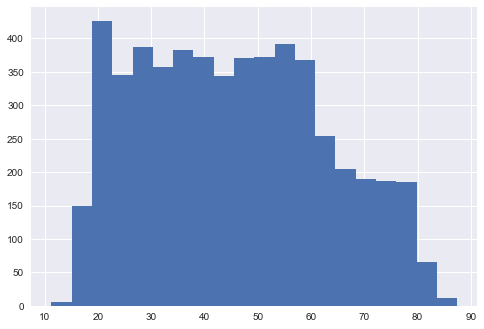

In [23]:
plt.hist(client['client_age'], 20)


In [24]:
#Cleaning Account
account = account.rename(columns={'district_id': 'account_district_id'})
account.head()

account_id  account_district_id         frequency    date
0         576                   55  POPLATEK MESICNE  930101
1        3818                   74  POPLATEK MESICNE  930101
2         704                   55  POPLATEK MESICNE  930101
3        2378                   16  POPLATEK MESICNE  930101
4        2632                   24  POPLATEK MESICNE  930102

In [25]:
account['date'] = account['date'].map(convert_int_to_date)
account['account_date_opened'] = account['date'].map(convert_date_to_days)
del account['date']

In [26]:
#Translation to English
def convert_freq_to_eng(x):
    if x == 'POPLATEK MESICNE':
        return 'MONTHLY'
    elif x == 'POPLATEK TYDNE':
        return 'WEEKLY'
    elif x == 'POPLATEK PO OBRATU':
        return 'TRANSACTION'
    else:
        return 'UNKNOWN'
    


In [27]:
account['frequency'] = account['frequency'].map(convert_freq_to_eng)
account = account.rename(columns={'frequency': 'statement_freq'})
account.head()
#End of Cleaning Account.

account_id  account_district_id statement_freq  account_date_opened
0         576                   55        MONTHLY                    0
1        3818                   74        MONTHLY                    0
2         704                   55        MONTHLY                    0
3        2378                   16        MONTHLY                    0
4        2632                   24        MONTHLY                    1

In [28]:
#Cleaining District
district.columns = ['district_id','district_name','region', 'total_inhabitants','num_munipalities_less_499','500_to_1999','2000_to_9999','greater_than_10000','num_cities','ratio_urban','avg_salary','unemp_rate_95','unemp_rate_96','enterpreneurs_per_1000','num_crimes95','num_crimes96']


In [29]:
#Unknown Data is represented as a question mark. Converting it to -1.
def convert_question_marks(x, typ):
    if x == '?':
        return -1
    elif typ == 'float':
        return float(x)
    else:
        return int(x)

In [30]:
district['unemp_rate_95'] = district['unemp_rate_95'].apply(convert_question_marks, args=('float',))
district['num_crimes95'] = district['num_crimes95'].apply(convert_question_marks, args=('int',))
#End of Cleaning District.


In [31]:
#cleaning loan 
# convert loan date to integer.

def get_year(x):
    return int(x/10000)

def get_mid2_dig(x):
    return int(x/100) % 100

def get_month(x):
    mth = get_mid2_dig(x)
    if mth > 50:
        return mth - 50
    else:
        return mth

def get_day(x):
    return x % 100

def convert_int_to_date(x):
    yr = get_year(x) + 1900
    mth = get_month(x)
    day = get_day(x)
    return datetime.datetime(yr, mth, day)


In [32]:
loan['date'] = loan['date'].map(convert_int_to_date)


In [33]:
loan['num_days_since_grant'] = loan['date'].map(convert_date_to_days)
del loan['date']
loan = loan.rename(columns={'amount': 'loan_amount', 'duration':'loan_duration', 'payments':'monthly_loan_payment', 'status':'loan_status'})

In [34]:
loan.head()
#End of cleaning loan

loan_id  account_id  loan_amount  loan_duration  monthly_loan_payment  \
0     5314        1787        96396             12                8033.0   
1     5316        1801       165960             36                4610.0   
2     6863        9188       127080             60                2118.0   
3     5325        1843       105804             36                2939.0   
4     7240       11013       274740             60                4579.0   

  loan_status  num_days_since_grant  
0           B                   185  
1           A                   191  
2           A                   208  
3           A                   214  
4           A                   248

In [35]:
typecount = disp['type'].value_counts()
disp.head()

disp_id  client_id  account_id       type
0        1          1           1      OWNER
1        2          2           2      OWNER
2        3          3           2  DISPONENT
3        4          4           3      OWNER
4        5          5           3  DISPONENT

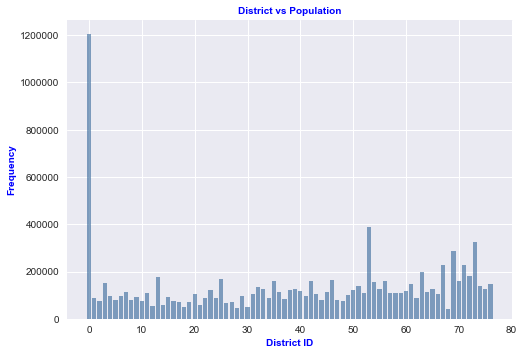

In [36]:
#### Data Visualization
#distirct id and population

f = plt.figure(1)
y = district['total_inhabitants']
x = district['district_id']
y_pos = np.arange(len(x))
plt.bar(y_pos, y, color=(0.2, 0.4, 0.6, 0.6))
# Custom Axis title
plt.xlabel('District ID', fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.ylabel('Frequency', fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.title('District vs Population', fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.savefig('fig_'+str('district_avgsal_pop1')+'.png', dpi=200)
plt.show()

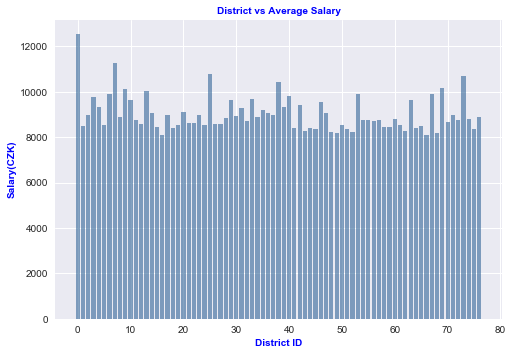

In [37]:
#district id and avg_salary
g = plt.figure(2)
y = district['avg_salary']
x = district['district_id']
y_pos = np.arange(len(x))
plt.bar(y_pos, y, color=(0.2, 0.4, 0.6, 0.6))
# Custom Axis title
plt.xlabel('District ID', fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.ylabel('Salary(CZK)', fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.title('District vs Average Salary',fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.savefig('fig_'+str('district_avgsal_pop2')+'.png', dpi=200)
plt.show()

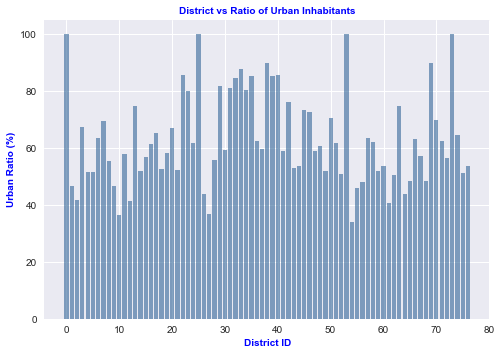

In [38]:
#urban ratio
b = district['ratio_urban']
a = district['district_id']
y_pos = np.arange(len(a))
plt.bar(y_pos, b, color=(0.2, 0.4, 0.6, 0.6))
#plt.xlim(1, 80)
# Custom Axis title
plt.xlabel('District ID', fontweight='bold', color = 'b', fontsize='10', horizontalalignment='center')
plt.ylabel('Urban Ratio (%)', fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.title('District vs Ratio of Urban Inhabitants',fontweight='bold', color = 'blue', fontsize='10', horizontalalignment='center')
plt.show()

In [39]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='ben0311', api_key='U1qTQSQaJmnRaRkwolq7')
import plotly.graph_objs as go

unemployment_rate95 = go.Scatter(
    x=district['district_id'],
    y=district['unemp_rate_95'],name='unemployment rate 95'
)

In [40]:
unemployment_rate96 = go.Scatter(
    x=district['district_id'],
    y=district['unemp_rate_96'],name='unemployment rate 96'
)

In [41]:
data = [unemployment_rate95, unemployment_rate96]
py.plot(data, filename='unemp')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ben0311/0 or inside your plot.ly account where it is named 'unemp'


'https://plot.ly/~ben0311/0'

In [42]:
crime95 = go.Scatter(
    x=district['district_id'],
    y=district['num_crimes95'],name='Number of Crimes 95'
)

In [43]:
crime96 = go.Scatter(
    x=district['district_id'],
    y=district['num_crimes96'],name='Number of Crimes 96'
)

In [44]:
data2 = [crime95, crime96]
py.plot(data2, filename='crime')

'https://plot.ly/~ben0311/2'

C:\Users\Bhargava\Anaconda3\lib\site-packages\matplotlib\pyplot.py:3317: RuntimeWarning:

Second argument is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.



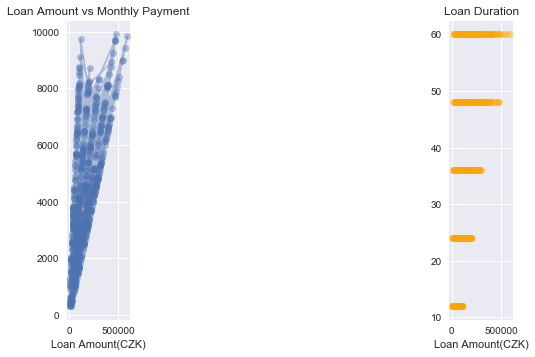

In [45]:
#Loan Amount vs. Monthly payment and Duration
df=pd.DataFrame({'x': loan['loan_amount'], 'y':loan['monthly_loan_payment'] , 'z': loan['loan_duration'] })
ax1=plt.subplot(121)
plt.plot( 'x', 'y', data=df, marker='o', alpha=0.4)
plt.xlabel("Loan Amount(CZK)")
ax1.set_title('Loan Amount vs Monthly Payment')
ax2=plt.subplot(122)
plt.plot( 'x','z', data=df, linestyle='none', marker='o', color="orange", alpha=0.3)
plt.xlabel("Loan Amount(CZK)")
ax2.set_title('Loan Duration')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=None)


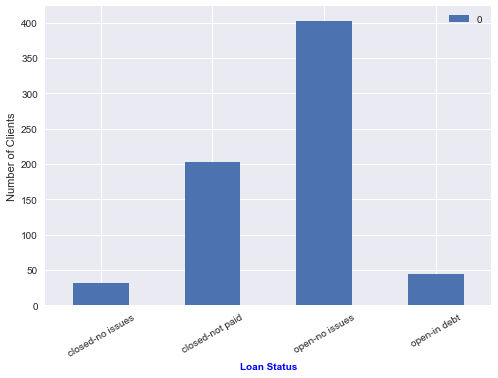

In [46]:
from collections import Counter

loan_status_num=Counter(loan['loan_status'])
loan_status_freq = pd.DataFrame.from_dict(loan_status_num, orient='index')
loangraph=loan_status_freq.plot(kind='bar')
plt.xlabel('Loan Status', fontweight='bold', color = 'blue', fontsize='10',horizontalalignment='center')
plt.ylabel('Number of Clients')
plt.xticks(rotation=30)
ax = plt.gca()
ax.set_xticklabels(["closed-no issues","closed-not paid","open-no issues","open-in debt"])
plt.savefig('fig_'+str('loan_status2')+'.png', dpi=200,bbox_inches="tight")
plt.show()

In [47]:
#loan status vs avg loan amount
from astropy.table import Table, Column
loan2 = loan.drop(loan.columns[[0, 1]], axis=1)
Table([loan['loan_status'], loan['loan_amount']])
loan2[loan2['loan_status']=='A'].mean()
loan2[loan2['loan_status']=='B'].mean()
loan2[loan2['loan_status']=='C'].mean()
loan2[loan2['loan_status']=='D'].mean()


loan_amount             249284.533333
loan_duration               46.133333
monthly_loan_payment      5286.644444
num_days_since_grant      1435.466667
dtype: float64

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

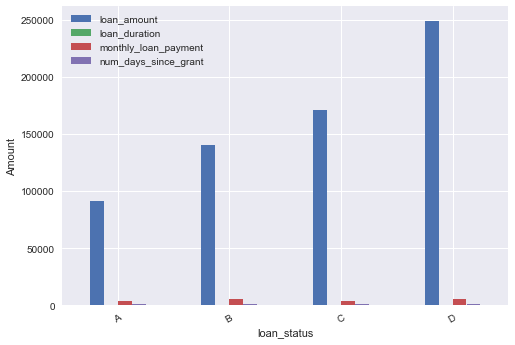

In [48]:
ax = loan2.groupby(by=['loan_status']).mean().plot.bar(legend=True)
ax.set_ylabel("Amount")
plt.xticks(rotation=30)

In [49]:
loan_amount_all= loan2.drop(["monthly_loan_payment", "num_days_since_grant", "loan_amount"], axis=1)
loan_duration_all=loan2.drop(["loan_amount", "loan_status_closed","num_days_since_grant","monthly_loan_payment"], axis=1)
loan_since_grant=loan2.drop(["monthly_loan_payment","loan_amount","loan_duration"], axis=1)
monthly_loan_payment2=loan2.drop(["num_days_since_grant","loan_amount","loan_status_closed","loan_duration"], axis=1)


ValueError: labels ['loan_status_closed'] not contained in axis

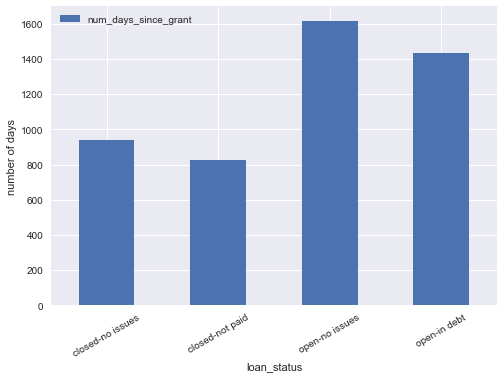

In [50]:
#graph loan since grant
loan_since_grant=loan2.drop(["monthly_loan_payment","loan_amount","loan_duration"], axis=1)
ax = loan_since_grant.groupby(by=['loan_status']).mean().plot.bar(legend=True)
ax.set_ylabel("number of days")
plt.xticks(rotation=30)
ax.set_xticklabels(["closed-no issues","closed-not paid","open-no issues","open-in debt"])
plt.savefig('fig_'+str('loan_since_grant')+'.png', dpi=200,bbox_inches="tight")
plt.show()


In [51]:
order.k_symbol.fillna('Unknown_Order_Type', inplace = True)

AttributeError: 'DataFrame' object has no attribute 'k_symbol'

In [52]:
def create_pig_table(df, cont_var, cat_var):
    # Group by the variable you want to plot
    groups = df[[cont_var,cat_var]].groupby(cat_var)
    # Calculate the size and incidence of each group
    pig_table = groups[cont_var].agg(['mean','size']).reset_index()
    pig_table.rename(columns={'mean': 'mean_'+cont_var,'size': 'size'},inplace=True)
    return pig_table

In [53]:
order['disc_order_amount'] = pd.qcut(order['order_amount'], 5)

In [54]:
order.groupby("disc_order_amount").size()

disc_order_amount
(0.999, 941.0]       1295
(941.0, 2064.0]      1294
(2064.0, 3231.0]     1295
(3231.0, 5353.5]     1294
(5353.5, 14882.0]    1293
dtype: int64

In [55]:
order['disc_order_amount'] = pd.cut(order["order_amount"],[0,3000,5000,10000,15000])
order.groupby("disc_order_amount").size()


disc_order_amount
(0, 3000]         3618
(3000, 5000]      1416
(5000, 10000]     1300
(10000, 15000]     137
dtype: int64

In [56]:
pig_table = create_pig_table(order,  "order_amount" ,"disc_order_amount")
pig_table

disc_order_amount  mean_order_amount  size
0         (0, 3000]        1398.409011  3618
1      (3000, 5000]        3832.651554  1416
2     (5000, 10000]        6992.337846  1300
3    (10000, 15000]       12061.868613   137

In [57]:
width = 0.5

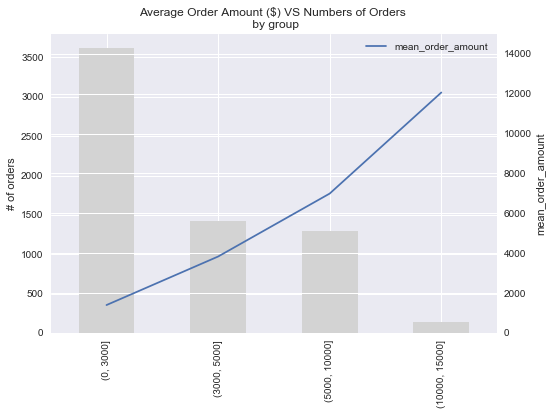

In [58]:
plt.ylabel("# of orders", rotation = 90,rotation_mode="anchor", ha = "center" )
pig_table["mean_order_amount"].plot(secondary_y = True)
pig_table["size"].plot(kind='bar', width = 0.5,color = "lightgray", edgecolor = "none") ## Add bars
plt.xticks(np.arange(len(pig_table)), pig_table["disc_order_amount"], rotation = 45)
plt.xlim([-width, len(pig_table)-width])
plt.ylim([0, 15000])
plt.ylabel("mean_order_amount", rotation = 90, rotation_mode="anchor", ha = "center")
plt.xlabel("disc_order_amount")
plt.legend(loc='upper right')
plt.title('Average Order Amount ($) VS Numbers of Orders \n by group')
#plt.tight_layout()
#plt.savefig('./figures/Chris/order/fig_'+str('mean_order_amount_VS_nbr_orders')+'.png', dpi=200)
plt.show()



In [59]:
pig_table = create_pig_table(order,  "order_amount" ,"order_k_symbol")
pig_table

order_k_symbol  mean_order_amount  size
0          Household        3987.840377  3502
1  Insurance payment        1291.216165   532
2            Leasing        2227.352199   341
3       Loan payment        4233.172245   717

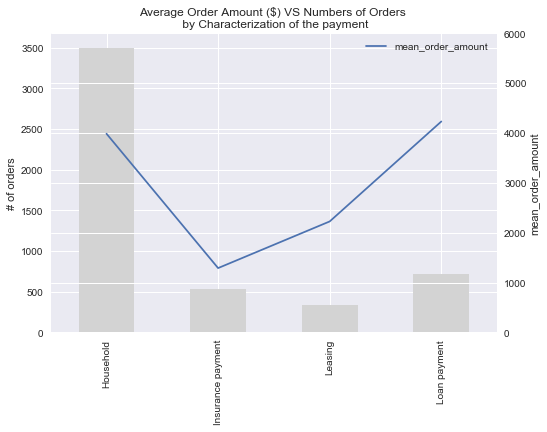

In [60]:
plt.ylabel("# of orders", rotation = 90,rotation_mode="anchor", ha = "center" )
pig_table["mean_order_amount"].plot(secondary_y = True)
pig_table["size"].plot(kind='bar', width = 0.5,color = "lightgray", edgecolor = "none") ## Add bars
# Show the group names
plt.xticks(np.arange(len(pig_table)), pig_table["order_k_symbol"], rotation = 45)
plt.xlim([-width, len(pig_table)-width])
plt.ylim([0, 6000])
plt.ylabel("mean_order_amount", rotation = 90, rotation_mode="anchor", ha = "center")
plt.xlabel("characterization of the payment")
plt.legend(loc='upper right')
plt.title('Average Order Amount ($) VS Numbers of Orders \n by Characterization of the payment')
#plt.tight_layout()
#plt.savefig('./figures/Chris/order/fig_'+str('order_k_symbol_VS_nbr_orders')+'.png', dpi=200)
plt.show()


In [61]:
pig_table = create_pig_table(order,  "order_amount" ,"order_recipient_bank")
print(pig_table)

   order_recipient_bank  mean_order_amount  size
0                    AB        3289.767823   519
1                    CD        3271.199563   458
2                    EF        3516.097308   483
3                    GH        3292.124846   487
4                    IJ        3278.619758   496
5                    KL        3370.794000   500
6                    MN        3136.368026   466
7                    OP        3064.782062   485
8                    QR        3254.558004   531
9                    ST        3308.537573   511
10                   UV        3358.124649   499
11                   WX        3360.729515   515
12                   YZ        3142.001536   521


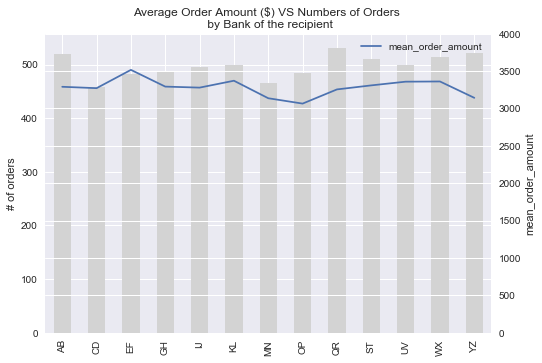

In [62]:
plt.ylabel("# of orders", rotation = 90,rotation_mode="anchor", ha = "center" )
pig_table["mean_order_amount"].plot(secondary_y = True)
pig_table["size"].plot(kind='bar', width = 0.5,color = "lightgray", edgecolor = "none") ## Add bars
# Show the group names
plt.xticks(np.arange(len(pig_table)), pig_table["order_recipient_bank"], rotation = 45)
plt.xlim([-width, len(pig_table)-width])
plt.ylim([0, 4000])
plt.ylabel("mean_order_amount", rotation = 90, rotation_mode="anchor", ha = "center")
plt.xlabel("characterization of the payment")
plt.legend(loc='upper right')
plt.title('Average Order Amount ($) VS Numbers of Orders \n by Bank of the recipient')
#plt.tight_layout()
#plt.savefig('./figures/Chris/order/fig_'+str('order_recipient_bank_VS_nbr_orders')+'.png', dpi=200)
plt.show()


In [63]:
def plot_histogram(df, col_name, bins=20):
    plt.hist(df[col_name], alpha=0.5, label=col_name, bins=bins)
    plt.legend(loc='upper right')
    plt.figtext(1.0, 0.2, df[col_name].describe().round(1))
    plt.title(col_name+' Distribution')
    plt.show()

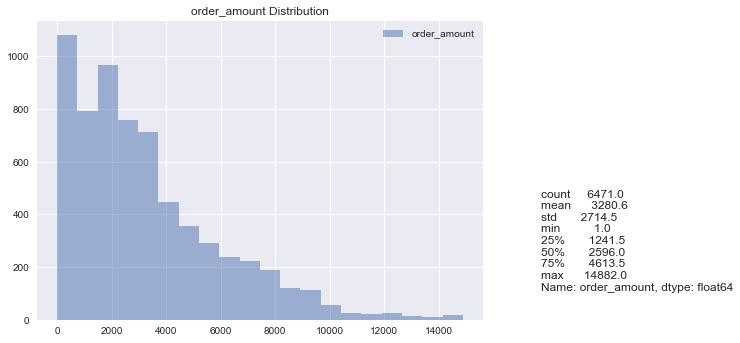

In [64]:
plot_histogram(order, 'order_amount')

In [65]:
order_amount_group_id = order.groupby('account_id')['order_amount'].agg(['sum','mean','size']).reset_index()
order_amount_group_id.rename(columns={'sum': 'sum_order_amount_by_account_id','mean': 'mean_order_amount_by_account_id','size': 'total_nbr_orders'},inplace=True)


In [66]:
order_amount_group_id.head()

account_id  sum_order_amount_by_account_id  \
0           1                          2452.0   
1           2                         10638.7   
2           3                          5001.0   
3           4                          3363.0   
4           5                          2668.0   

   mean_order_amount_by_account_id  total_nbr_orders  
0                          2452.00                 1  
1                          5319.35                 2  
2                          1667.00                 3  
3                          1681.50                 2  
4                          2668.00                 1

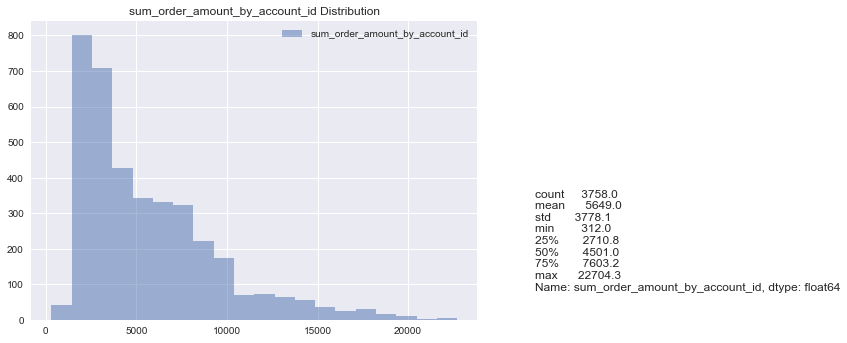

In [67]:
plot_histogram(order_amount_group_id, 'sum_order_amount_by_account_id')


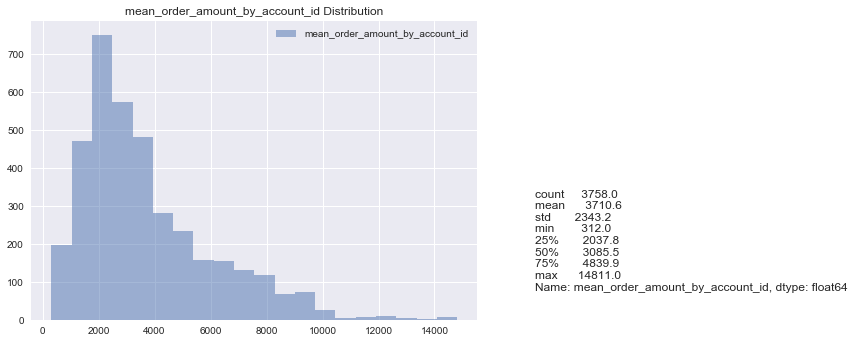

In [68]:
plot_histogram(order_amount_group_id, 'mean_order_amount_by_account_id')


In [69]:
order_type_group_id = order.groupby(['account_id','order_k_symbol'])['order_amount'].agg(['mean','size']).unstack().reset_index()
order_type_group_id.rename(columns={'mean': 'mean_order_amount_of','size': 'nbr_orders'},inplace=True)
print(order_type_group_id.head())


               account_id mean_order_amount_of                            \
order_k_symbol                       Household Insurance payment Leasing   
0                       1               2452.0               NaN     NaN   
1                       2               7266.0               NaN     NaN   
2                       3               1135.0            3539.0     NaN   
3                       4               1681.5               NaN     NaN   
4                       5               2668.0               NaN     NaN   

                            nbr_orders                                         
order_k_symbol Loan payment  Household Insurance payment Leasing Loan payment  
0                       NaN        1.0               NaN     NaN          NaN  
1                    3372.7        1.0               NaN     NaN          1.0  
2                       NaN        1.0               1.0     NaN          NaN  
3                       NaN        2.0               NaN     NaN   

In [70]:
order_type_group_id.columns = [' '.join(col).strip() for col in order_type_group_id.columns.values]


In [71]:
order_b = order_amount_group_id.merge(order_type_group_id, how='inner', left_on='account_id', right_on='account_id')


In [72]:
trans.isnull().sum()

trans_id                      0
account_id                    0
date                          0
trans_amount                  0
balance_after_trans           0
trans_bank_partner       782812
trans_account_partner    760931
trans_type                16666
trans_operation          183114
trans_k_symbol           535314
dtype: int64

In [73]:
(trans.isnull().sum()/len(trans)).round(2)

trans_id                 0.00
account_id               0.00
date                     0.00
trans_amount             0.00
balance_after_trans      0.00
trans_bank_partner       0.74
trans_account_partner    0.72
trans_type               0.02
trans_operation          0.17
trans_k_symbol           0.51
dtype: float64

In [74]:
trans.trans_k_symbol.fillna('Unknown_Transaction_Type', inplace = True)

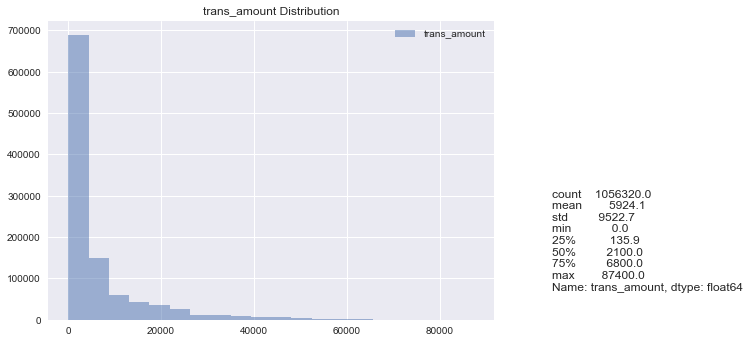

In [75]:
plot_histogram(trans, 'trans_amount')

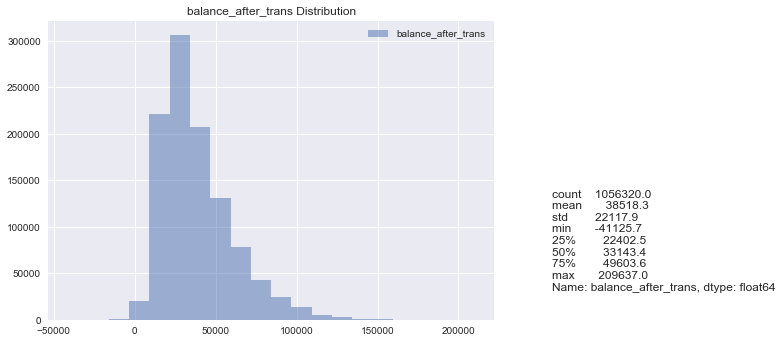

In [76]:
plot_histogram(trans, 'balance_after_trans')


In [77]:
def create_pig_table(df, cont_var, cat_var):
    # Group by the variable you want to plot
    groups = df[[cont_var,cat_var]].groupby(cat_var)
    # Calculate the size and incidence of each group
    pig_table = groups[cont_var].agg(['mean','size']).reset_index()
    pig_table.rename(columns={'mean': 'mean_'+cont_var,'size': 'size'},inplace=True)
    return pig_table


In [78]:
trans['disc_trans_amount'] = pd.qcut(trans['trans_amount'], 5)

In [79]:
trans.groupby("disc_trans_amount").size()

disc_trans_amount
(-0.001, 92.2]       211272
(92.2, 870.0]        211302
(870.0, 3400.0]      211780
(3400.0, 9120.0]     210748
(9120.0, 87400.0]    211218
dtype: int64

In [80]:
trans['disc_trans_amount'] = pd.cut(trans["trans_amount"],[0,100,2500,5000,10000,100000])


In [81]:
trans.groupby("disc_trans_amount").size()

disc_trans_amount
(0, 100]           225242
(100, 2500]        337789
(2500, 5000]       156765
(5000, 10000]      139705
(10000, 100000]    196805
dtype: int64

In [82]:
pig_table = create_pig_table(trans,  "trans_amount" ,"disc_trans_amount")
pig_table

disc_trans_amount  mean_trans_amount    size
0          (0, 100]          32.334756  225242
1       (100, 2500]         872.937866  337789
2      (2500, 5000]        3631.024176  156765
3     (5000, 10000]        6992.245517  139705
4   (10000, 100000]       22405.794779  196805

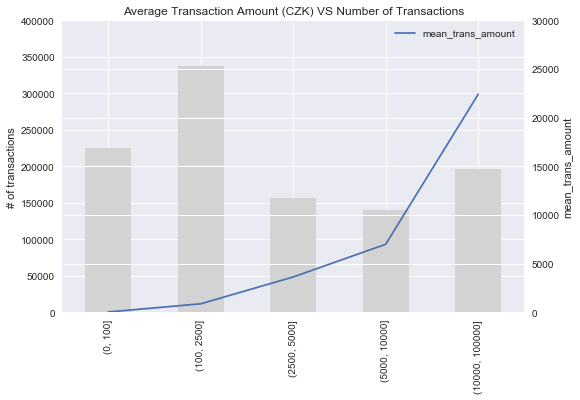

In [83]:
plt.ylim([0, 400000])
plt.ylabel("# of transactions", rotation = 90,rotation_mode="anchor", ha = "center" )
pig_table["mean_trans_amount"].plot(secondary_y = True)
pig_table["size"].plot(kind='bar', width = 0.5,color = "lightgray", edgecolor = "none") ## Add bars
plt.xticks(np.arange(len(pig_table)), pig_table["disc_trans_amount"], rotation = 45)
plt.xlim([-width, len(pig_table)-width])
plt.ylim([0, 30000])
plt.ylabel("mean_trans_amount", rotation = 90, rotation_mode="anchor", ha = "center")
plt.xlabel("disc_trans_amount")
plt.legend(loc='upper right')
plt.title('Average Transaction Amount (CZK) VS Number of Transactions')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2)
plt.margins(1)
#plt.savefig('./figures/Chris/fig_'+str('mean_trans_amount_VS_nbr_trans')+'.png', dpi=200)
plt.show()

In [84]:
pig_table = create_pig_table(trans,  "trans_amount" ,"trans_k_symbol")
pig_table

trans_k_symbol  mean_trans_amount    size
0                              Household        4222.304798  118065
1                      Insurance payment        1306.767189   18500
2                      Interest credited         150.019603  183114
3                           Loan payment        4068.652673   13580
4                        Old-age pension        5520.209572   30338
5                  Payment for statement          17.239195  155832
6  Sanction interest if negative balance          23.882879    1577
7               Unknown_Transaction_Type       10241.078617  535314

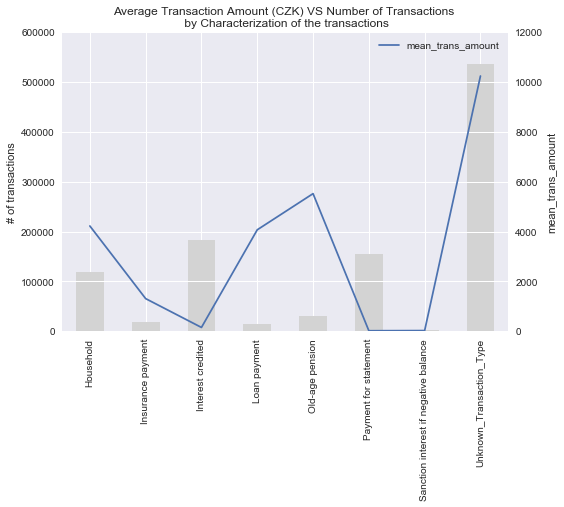

In [85]:
plt.ylim([0, 600000])
plt.ylabel("# of transactions", rotation = 90,rotation_mode="anchor", ha = "center" )
pig_table["mean_trans_amount"].plot(secondary_y = True)
pig_table["size"].plot(kind='bar', width = 0.5,color = "lightgray", edgecolor = "none") ## Add bars
# Show the group names
plt.xticks(np.arange(len(pig_table)), pig_table["trans_k_symbol"], rotation = 45)
plt.xlim([-width, len(pig_table)-width])
plt.ylim([0, 12000])
plt.ylabel("mean_trans_amount", rotation = 90, rotation_mode="anchor", ha = "center")
plt.xlabel("characterization of the transactions",rotation=0)
plt.legend(loc='upper right')
plt.margins(1)
plt.title('Average Transaction Amount (CZK) VS Number of Transactions \n by Characterization of the transactions')
#plt.savefig('./figures/Chris/fig_'+str('trans_k_symbol_VS_nbr_trans')+'.png', dpi=200)
plt.show()


In [86]:
trans.trans_type.fillna('Unknown_Transaction_Type', inplace = True)
pig_table = create_pig_table(trans,  "trans_amount" ,"trans_type")
pig_table

trans_type  mean_trans_amount    size
0                    Credit        7967.434882  405083
1  Unknown_Transaction_Type       12516.726149   16666
2                Withdrawal        4446.653531  634571

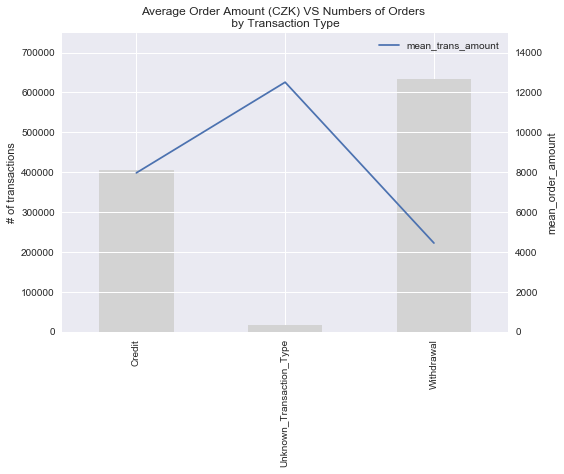

In [87]:
plt.ylim([0, 750000])
plt.ylabel("# of transactions", rotation = 90,rotation_mode="anchor", ha = "center" )
pig_table["mean_trans_amount"].plot(secondary_y = True)
pig_table["size"].plot(kind='bar', width = 0.5,color = "lightgray", edgecolor = "none") ## Add bars
plt.xticks(np.arange(len(pig_table)), pig_table["trans_type"], rotation = 45)
plt.xlim([-width, len(pig_table)-width])
plt.ylim([0, 15000])
plt.xlabel("Transaction Type")
plt.ylabel("mean_order_amount", rotation = 90, rotation_mode="anchor", ha = "center")
plt.legend(loc='upper right')
plt.title('Average Order Amount (CZK) VS Numbers of Orders \n by Transaction Type ')
plt.subplots_adjust(hspace=1)
plt.show()


In [88]:
trans_amount_group_id = trans.groupby('account_id')['trans_amount'].agg(['sum','mean','size']).reset_index()
trans_amount_group_id.rename(columns={'sum': 'alltime_sum_trans_amount_by_account_id','mean': 'alltime_mean_trans_amount_by_account_id','size': 'alltime_total_nbr_trans'},inplace=True)
trans_amount_group_id.head()

account_id  alltime_sum_trans_amount_by_account_id  \
0           1                                375174.5   
1           2                               3151479.3   
2           3                                295021.8   
3           4                                350971.4   
4           5                                166881.4   

   alltime_mean_trans_amount_by_account_id  alltime_total_nbr_trans  
0                              1569.767782                      239  
1                              6593.052929                      478  
2                              2521.553846                      117  
3                              1886.943011                      186  
4                              1986.683333                       84

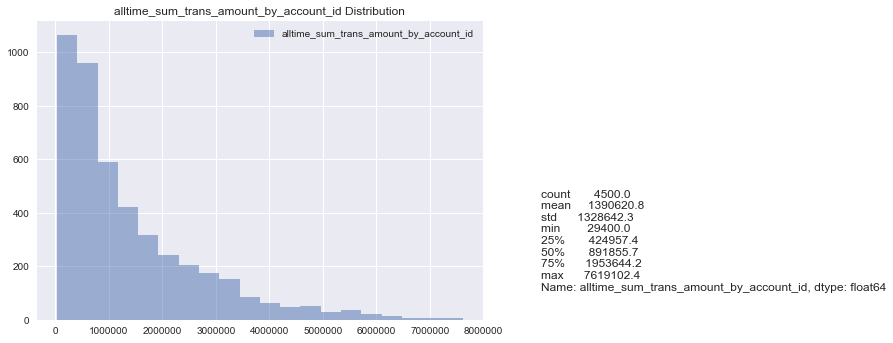

In [89]:
plot_histogram(trans_amount_group_id, 'alltime_sum_trans_amount_by_account_id')

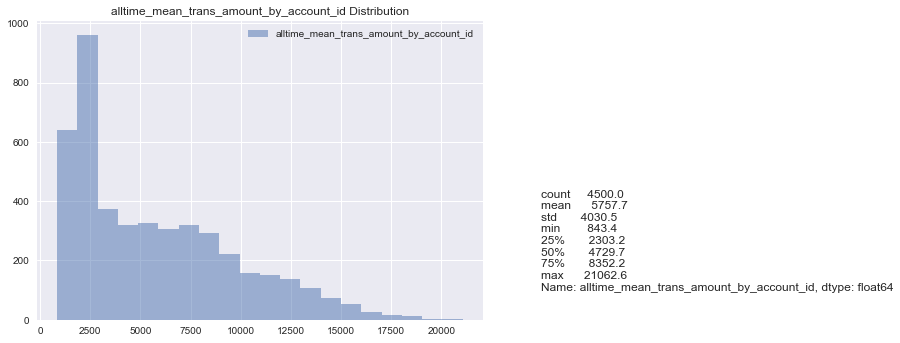

In [90]:
plot_histogram(trans_amount_group_id, 'alltime_mean_trans_amount_by_account_id')


In [91]:
trans_k_group_id = trans.groupby(['account_id','trans_k_symbol'])['trans_amount'].agg(['mean','size']).unstack().reset_index()
trans_k_group_id.rename(columns={'mean': 'mean_trans_amount_of','size': 'nbr_trans'},inplace=True)
# reset multi-index and rename colname
trans_k_group_id.columns = [' '.join(col).strip() for col in trans_k_group_id.columns.values]
print(trans_k_group_id.head())


   account_id  mean_trans_amount_of Household  \
0           1                          2452.0   
1           2                          7266.0   
2           3                          1135.0   
3           4                          2078.0   
4           5                          2668.0   

   mean_trans_amount_of Insurance payment  \
0                                     NaN   
1                                     NaN   
2                                  3539.0   
3                                     NaN   
4                                     NaN   

   mean_trans_amount_of Interest credited  mean_trans_amount_of Loan payment  \
0                               68.122222                                NaN   
1                              153.107143                             3372.7   
2                              115.000000                                NaN   
3                               91.466667                                NaN   
4                              104

In [92]:
trans_type_group_id = trans.groupby(['account_id','trans_type'])['trans_amount'].agg(['mean','size']).unstack().reset_index()
trans_type_group_id.rename(columns={'mean': 'mean_trans_amount_of','size': 'nbr_trans'},inplace=True)
# reset multi-index and rename colname
trans_type_group_id.columns = [' '.join(col).strip() for col in trans_type_group_id.columns.values]
print(trans_type_group_id.head())


   account_id  mean_trans_amount_of Credit  \
0           1                  1905.102941   
1           2                 10506.930921   
2           3                  3762.152174   
3           4                  2959.169231   
4           5                  2785.285714   

   mean_trans_amount_of Unknown_Transaction_Type  \
0                                            NaN   
1                                   10354.380952   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   mean_trans_amount_of Withdrawal  nbr_trans Credit  \
0                      1320.102190             102.0   
1                      4383.553443             152.0   
2                      1717.785915              46.0   
3                      1310.953719              65.0   
4                      1416.253061              35.0   

   nbr_trans Unknown_Transaction_Type  nbr_trans Withdrawal  
0          

In [93]:
startdate = datetime.datetime(1993,1,1)
enddate = datetime.datetime(1999,1,1)
df_cut_list=[]
trans['date'] = pd.to_datetime(trans['date'], format='%Y-%m-%d')
def date_interval(df, agg_interval = [1,3]):
    for i in agg_interval:
        startdate = enddate-datetime.timedelta(i*365.25)
        interval = (df['date']>= startdate) & (df['date'] <= enddate)
        df_cut = trans[interval]
        df_cut = df_cut.groupby('account_id')['trans_amount'].agg(['sum','mean','size']).reset_index()
        df_cut.rename(columns={'sum': str(i)+'yr_sum_trans_amount_by_account_id','mean': str(i)+'yr_mean_trans_amount_by_account_id','size': str(i)+'yr_total_nbr_trans'},inplace=True)
        df_cut_list.append(df_cut)
    return(df_cut_list)
# assign aggregated by 2 interval (latest 1 yr, latest 3 yrs)    
df1,df2= date_interval(trans)
# number of days since last transaction (till enddate = datetime.datetime(1999,1,1)), for recency calculation
### Not useful
#trans['recency'] = enddate-trans['date']
#df3 = trans.groupby(['account_id'])['recency'].agg(['min']).unstack().reset_index()
#df3.rename(columns={'min': 'recency'},inplace=True)
#print(df3.describe())

# Calculate sum transaction growth in the 3 years
df_cut_list=[]

In [94]:
def sum_in_yr(df, agg_interval = [1,2,3]):
    enddate = datetime.datetime(1999,1,1)
    for i in agg_interval:
        startdate = enddate-datetime.timedelta((i)*365.25)
        enddate = enddate-datetime.timedelta((i-1)*365.25)
        interval = (df['date']>= startdate) & (df['date'] <= enddate)
        df_cut = df[interval]
        df_cut = df_cut.groupby('account_id')['trans_amount'].agg(['sum']).reset_index()
        df_cut.rename(columns={'sum': 'sum_trans_amount_by_account_id_in_yr'+str(startdate.year+1)},inplace=True)
        df_cut_list.append(df_cut)
    return(df_cut_list)

In [95]:
sum_per_yr_list= sum_in_yr(trans)

In [96]:
trans_b = trans_amount_group_id.merge(trans_k_group_id, how='inner', left_on='account_id', right_on='account_id')
trans_b = trans_b.merge(trans_type_group_id, how='inner', left_on='account_id', right_on='account_id')
trans_b = trans_b.merge(df1, how='inner', left_on='account_id', right_on='account_id')
trans_b = trans_b.merge(df2, how='inner', left_on='account_id', right_on='account_id')

In [97]:
trans_bi = trans_b.merge(sum_per_yr_list[0], how='outer', left_on='account_id', right_on='account_id')
trans_bi = trans_bi.merge(sum_per_yr_list[1], how='outer', left_on='account_id', right_on='account_id')
trans_bi = trans_bi.merge(sum_per_yr_list[2], how='outer', left_on='account_id', right_on='account_id')

In [98]:
trans_bi['trans_ratio_98_97'] = trans_bi['sum_trans_amount_by_account_id_in_yr1998']/trans_bi['sum_trans_amount_by_account_id_in_yr1997']
trans_bi['trans_ratio_97_96'] = trans_bi['sum_trans_amount_by_account_id_in_yr1997']/trans_bi['sum_trans_amount_by_account_id_in_yr1996']

# drop intermediate cols
trans_bi= trans_bi.drop(['sum_trans_amount_by_account_id_in_yr1998',
                         'sum_trans_amount_by_account_id_in_yr1997',
                         'sum_trans_amount_by_account_id_in_yr1996'], axis=1)


In [99]:
trans_b_order_b = trans_b.merge(order_b, how='outer', left_on='account_id', right_on='account_id')


In [100]:
table = client.merge(disp, how='outer', left_on='client_id', right_on='client_id')
table = table.merge(trans_b_order_b, how='outer', left_on='account_id', right_on='account_id')
table = table.merge(account, how='outer', left_on='account_id', right_on='account_id')
table = table.merge(loan, how='outer', left_on='account_id', right_on='account_id')
table = table.merge(disp, how='outer', left_on='disp_id', right_on='disp_id')
table = table.merge(card, how='outer', left_on='disp_id', right_on='disp_id')
table = table.merge(district, how='outer', left_on='client_district_id', right_on='district_id')


In [101]:
table.head()

client_id_x  client_district_id  birth_year  age  age_group  birth_month  \
0            1                  18        1970   29         29           12   
1          420                  18        1978   21         21            3   
2          499                  18        1935   64         64            7   
3          519                  18        1980   19         19            4   
4          682                  18        1979   20         20           10   

  gender  client_age client_gender  disp_id      ...       2000_to_9999  \
0      F   28.071233             F        1      ...                  2   
1      M   20.819178             M      420      ...                  2   
2      F   63.528767             F      499      ...                  2   
3      M   18.731507             M      519      ...                  2   
4      M   19.210959             M      682      ...                  2   

  greater_than_10000  num_cities  ratio_urban  avg_salary  unemp_rate_95  \
0                  1           4         65.3        8968           2.83   
1                  1           4         65.3        8968           2.83   
2                  1           4         65.3        8968           2.83   
3                  1           4         65.3        8968           2.83   
4                  1           4         65.3        8968           2.83   

   unemp_rate_96  enterpreneurs_per_1000  num_crimes95  num_crimes96  
0           3.35                     131          1740          1910  
1           3.35                     131          1740          1910  
2           3.35                     131          1740          1910  
3           3.35                     131          1740          1910  
4           3.35                     131          1740          1910  

[5 rows x 85 columns]

In [102]:
table.columns = table.columns.str.replace(r'.1', '')
table.columns = table.columns.str.replace(r'.2', '')
table.columns = table.columns.str.replace(r'.3', '')
table_col_list = pd.DataFrame(list(table))

C:\Users\Bhargava\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



AttributeError: Unknown property height

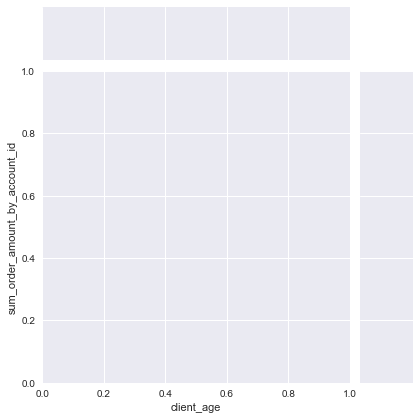

In [103]:
sns.set(style="darkgrid")
x_cols = ['client_age']
y_cols = [col for col in table.columns if 'order' in col]
for x_col in x_cols:
    for y_col in y_cols:
        g = sns.jointplot(x_col, y_col, data=table, color="b",kind="hex", height =7, joint_kws={"alpha": 0.4})
        

C:\Users\Bhargava\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



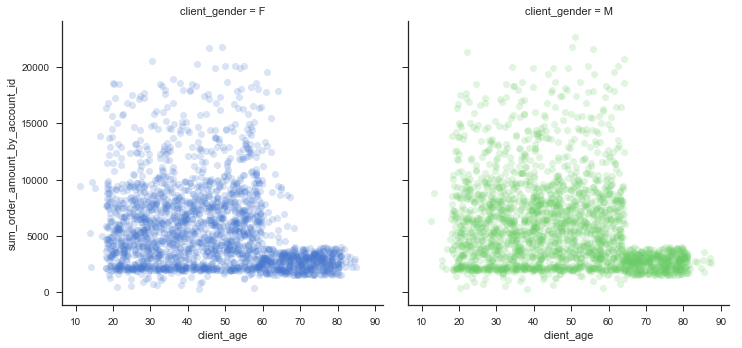

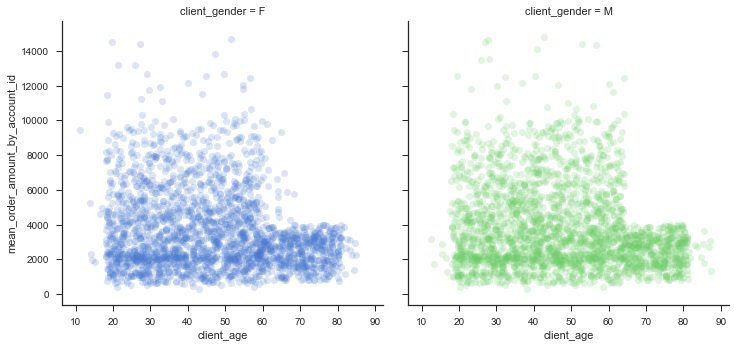

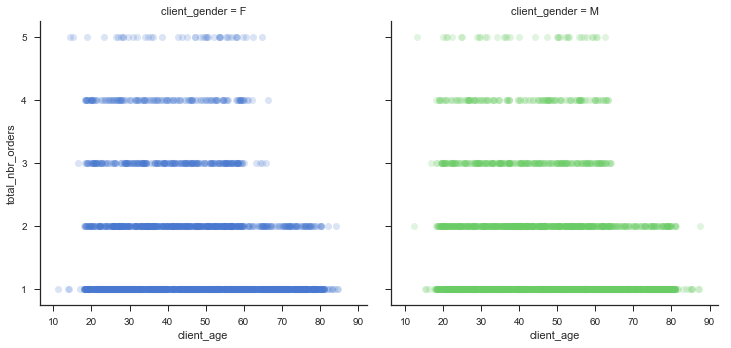

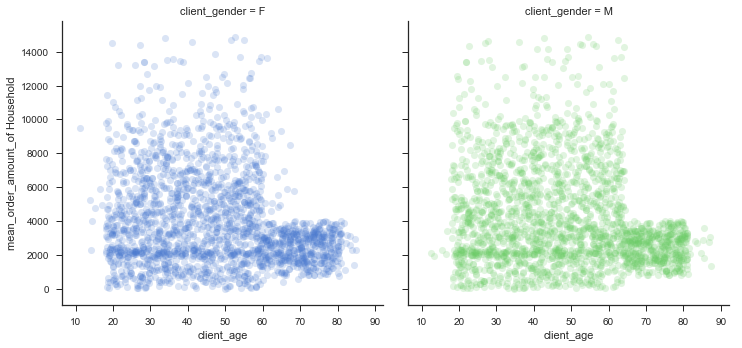

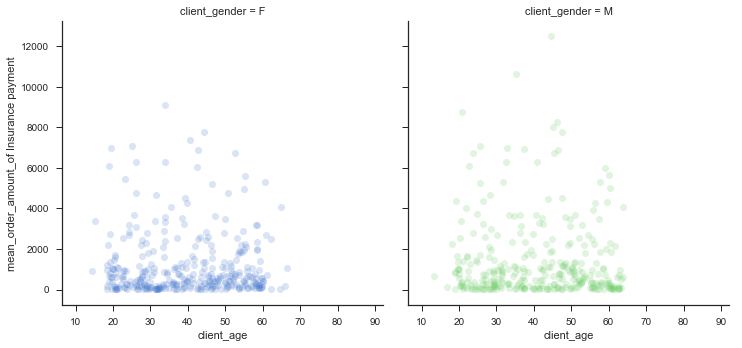

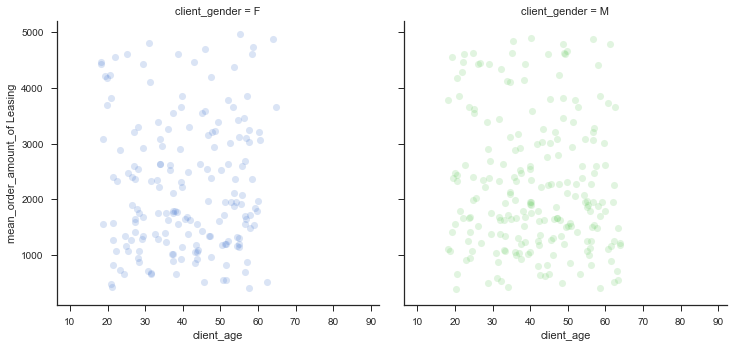

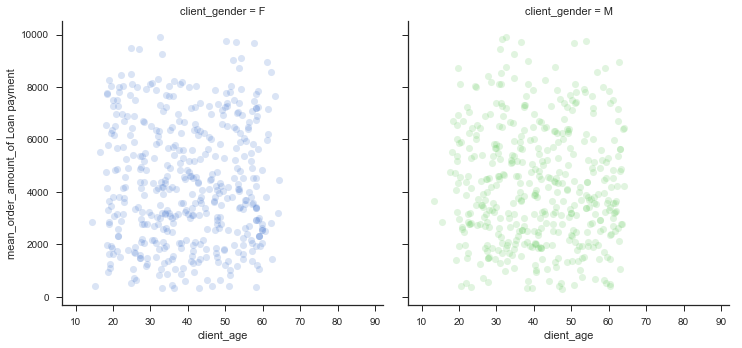

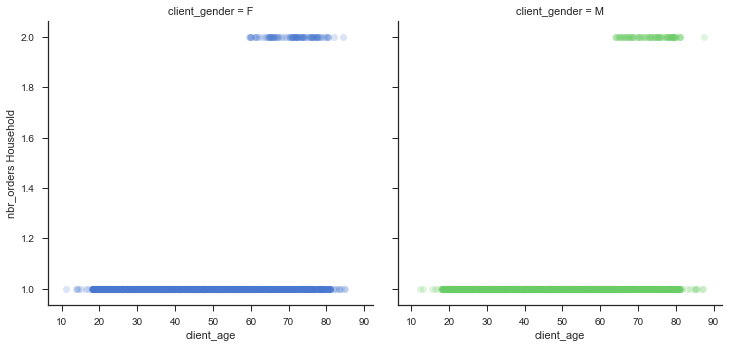

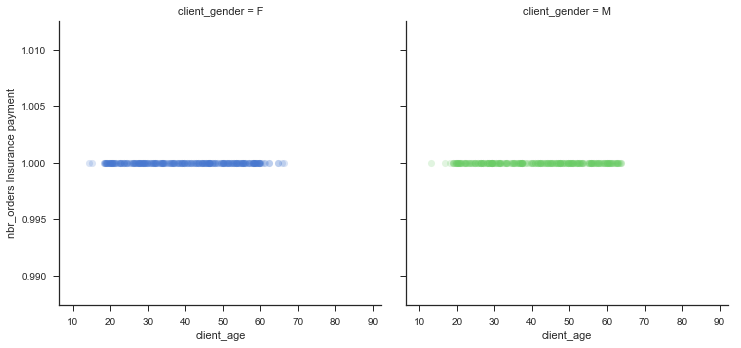

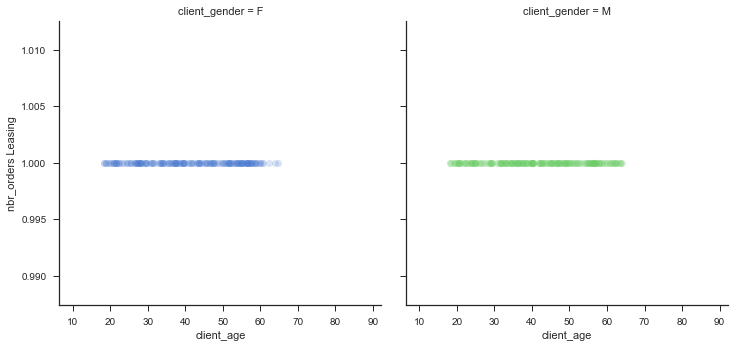

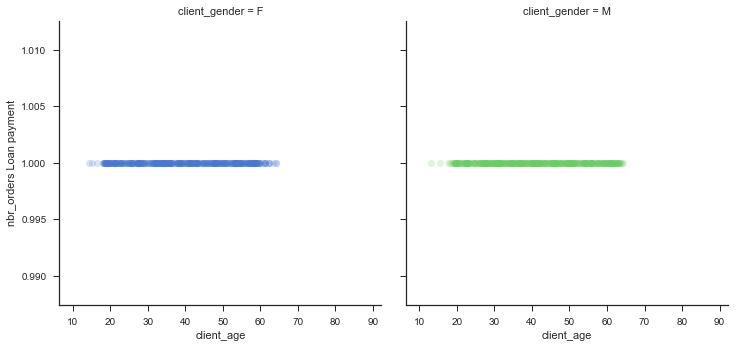

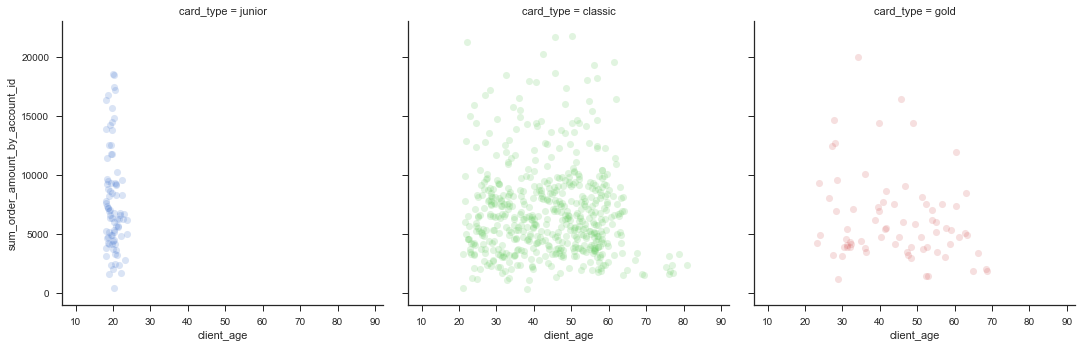

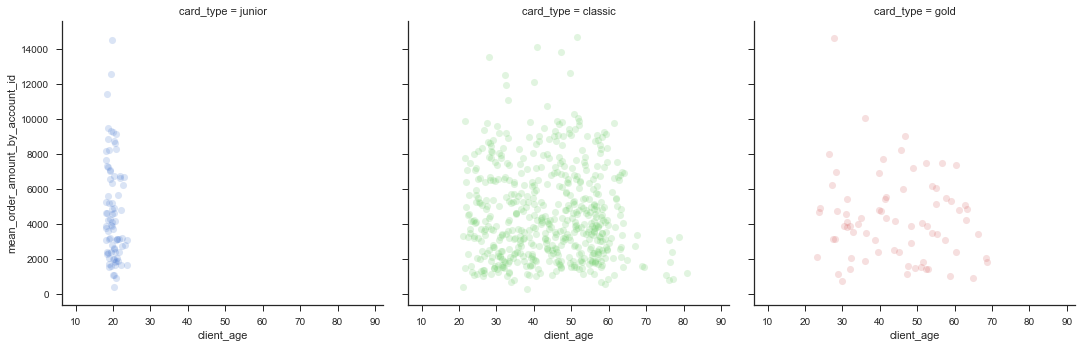

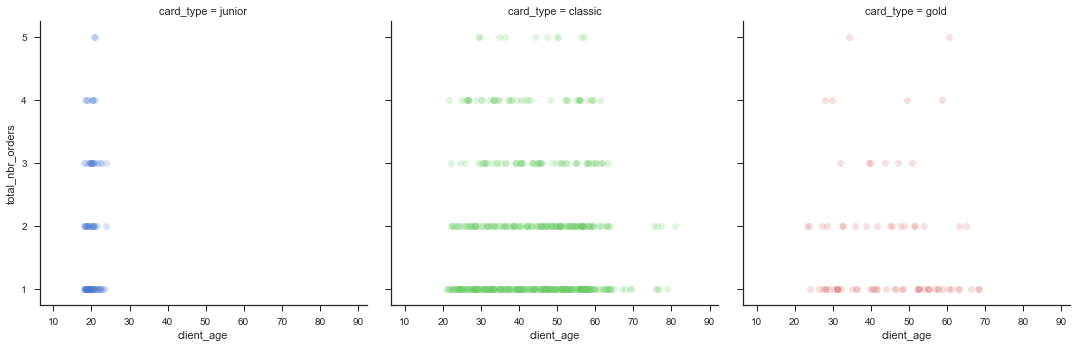

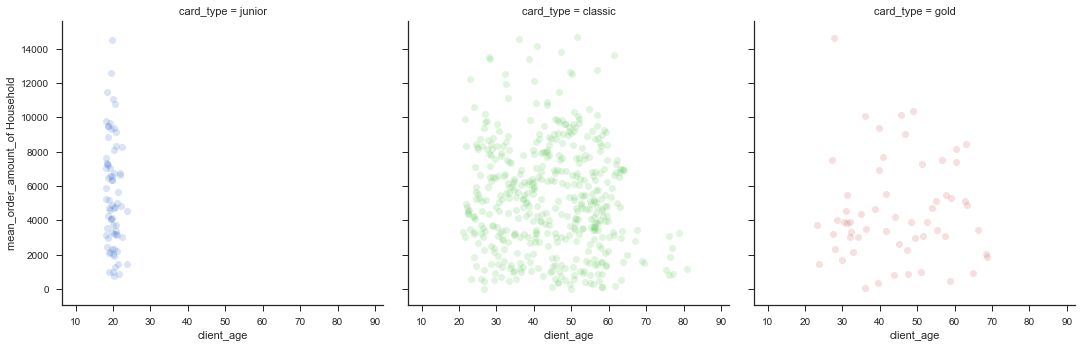

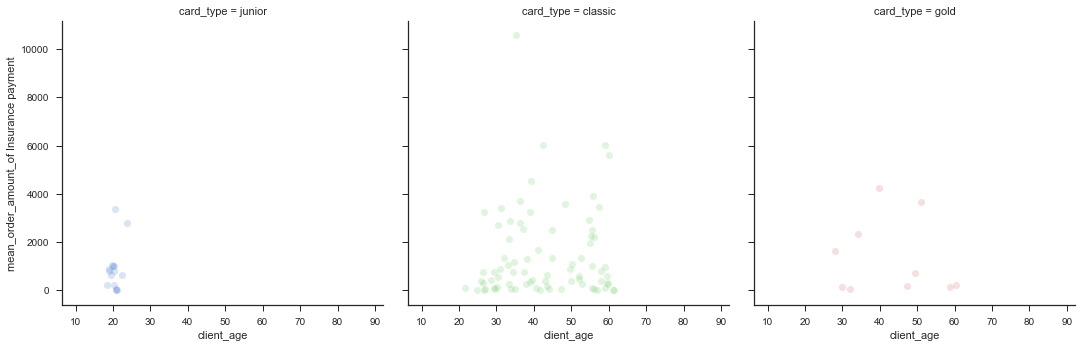

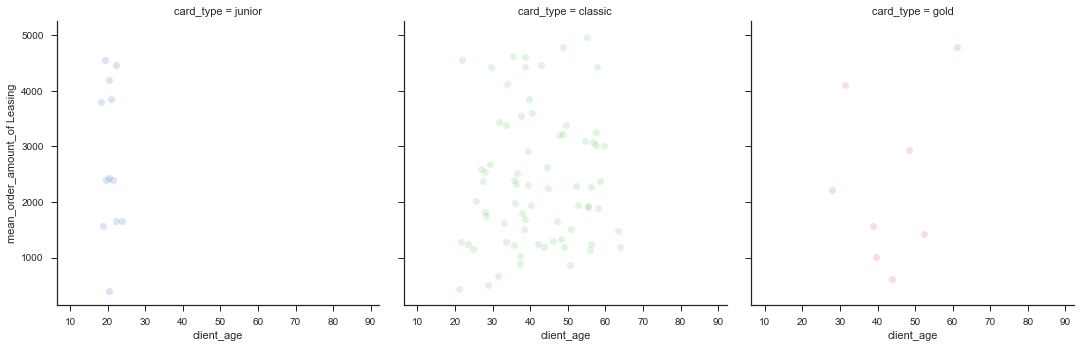

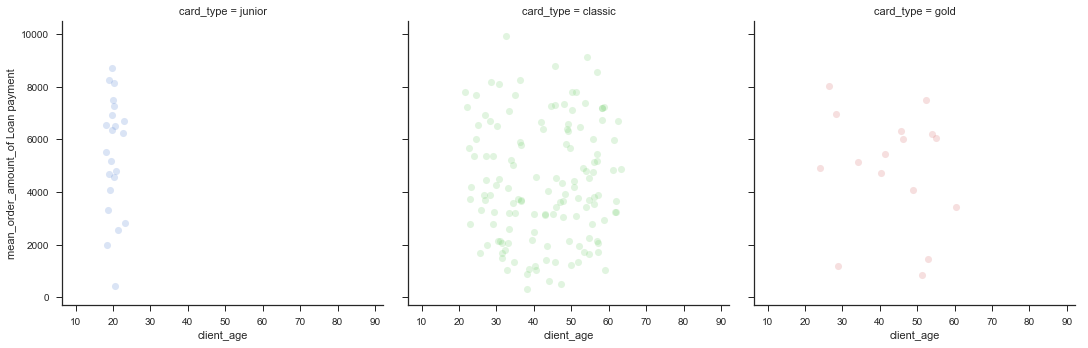

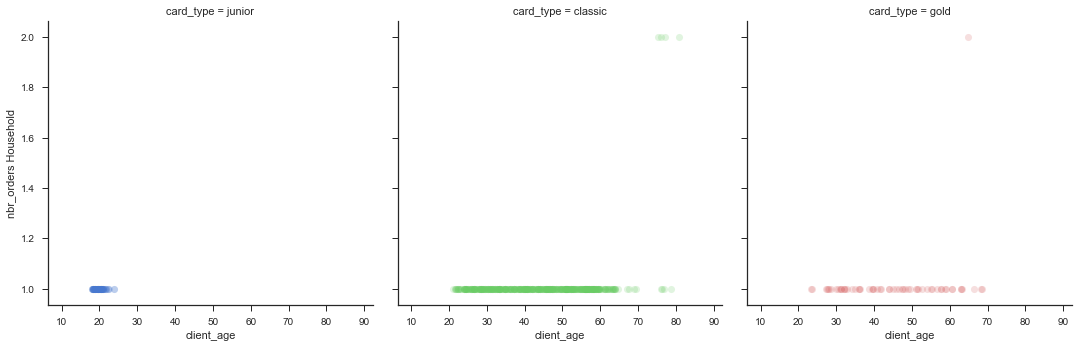

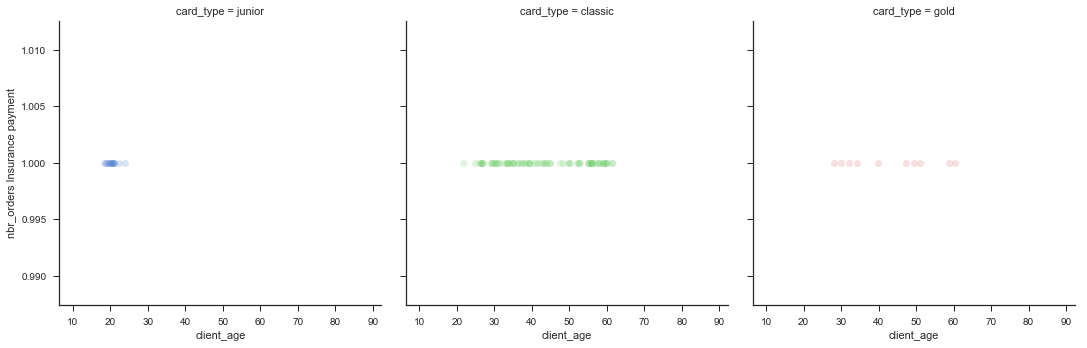

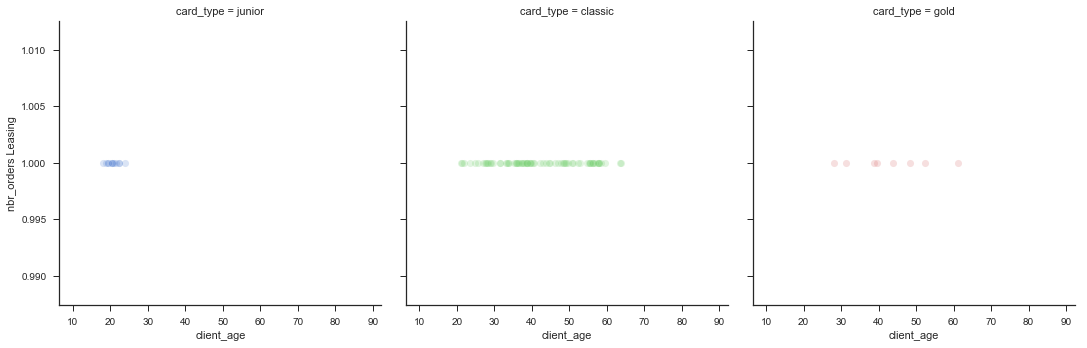

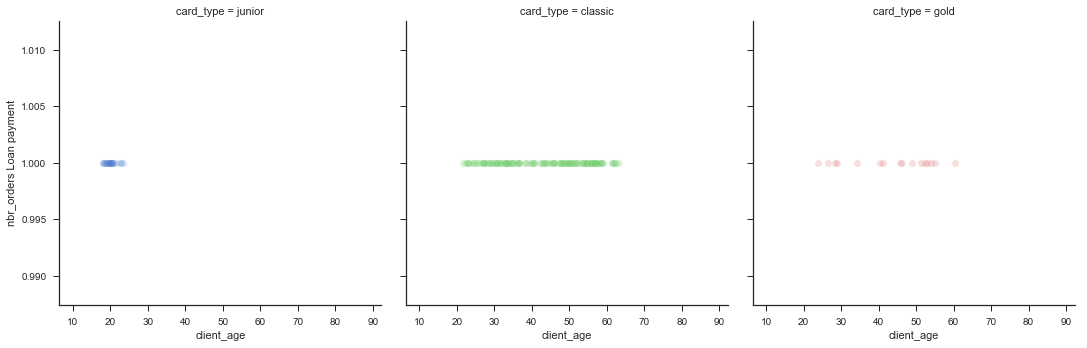

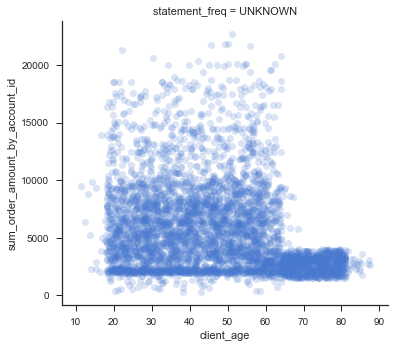

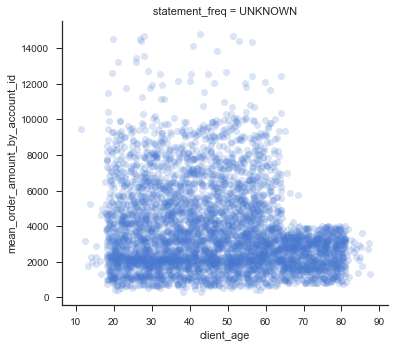

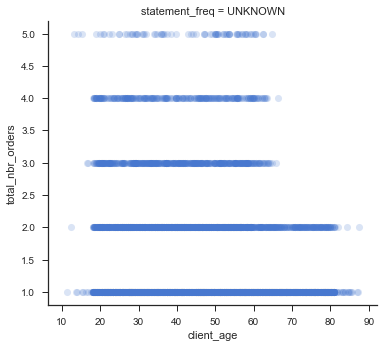

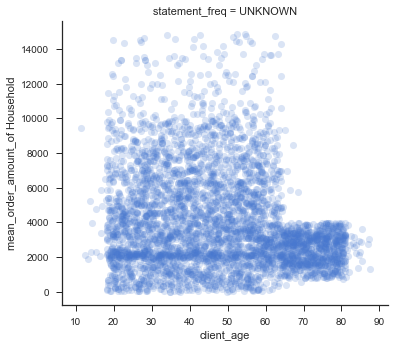

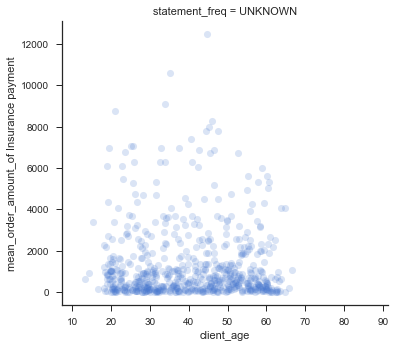

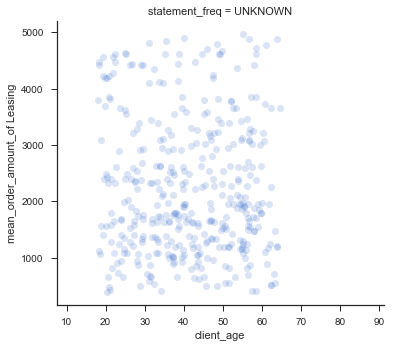

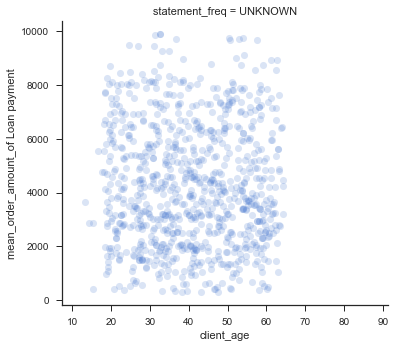

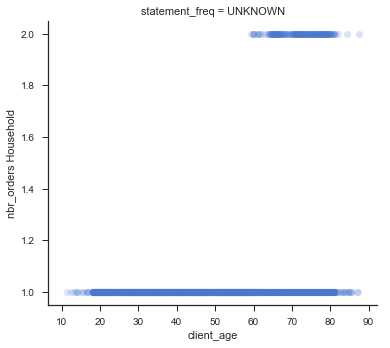

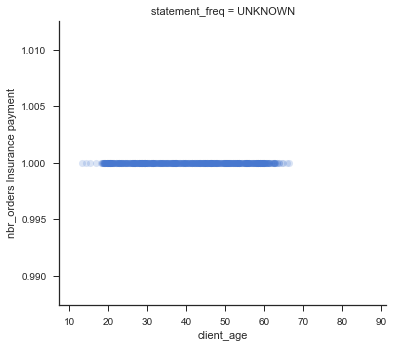

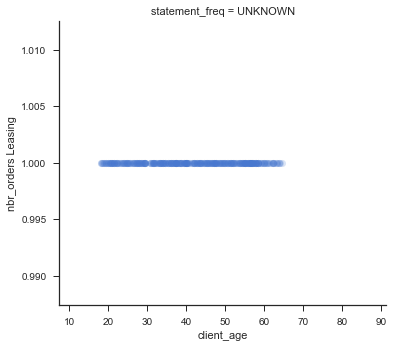

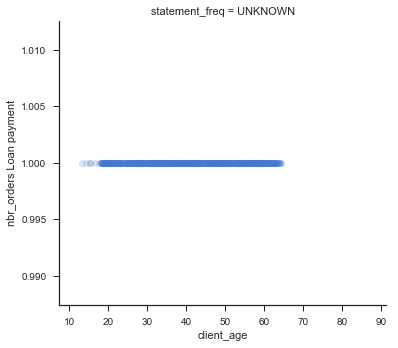

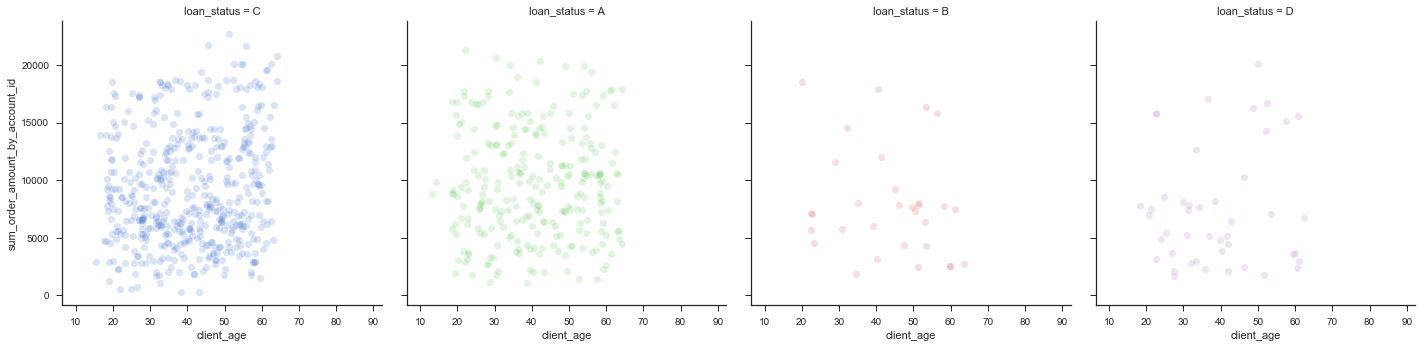

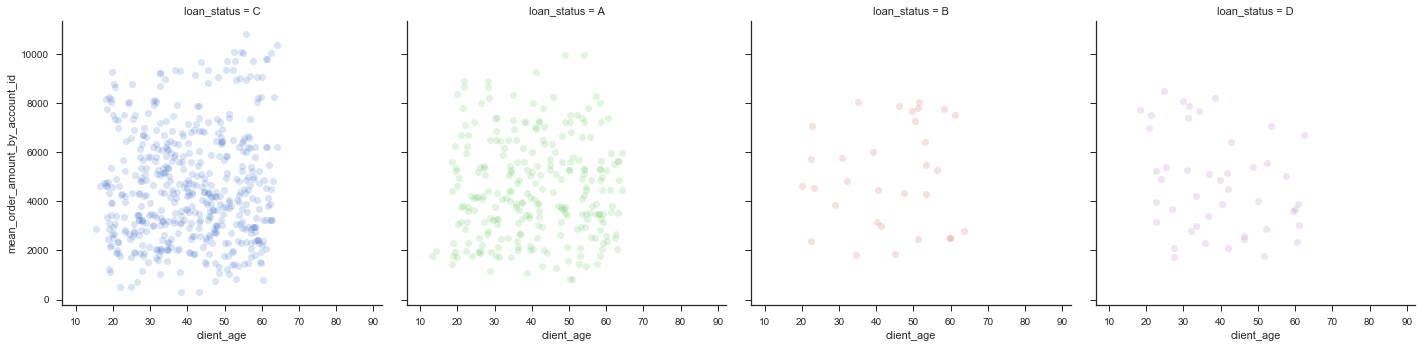

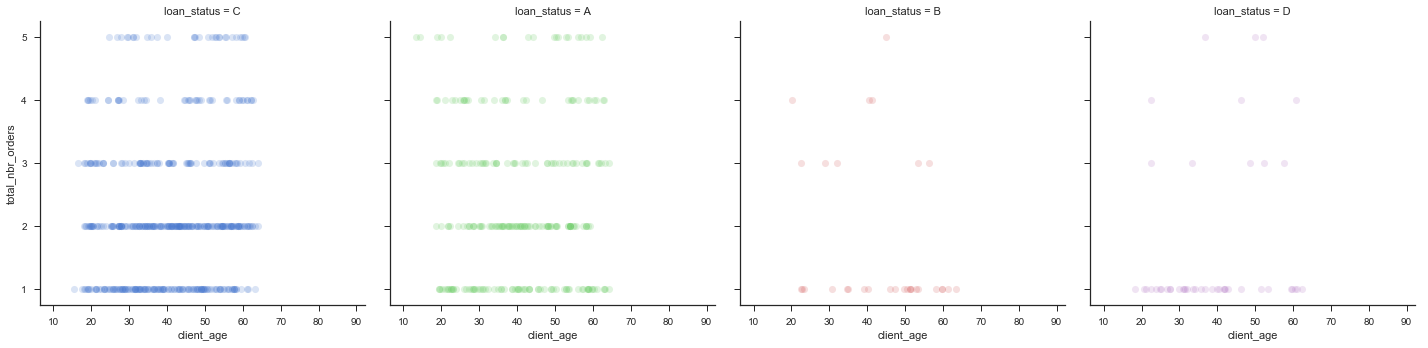

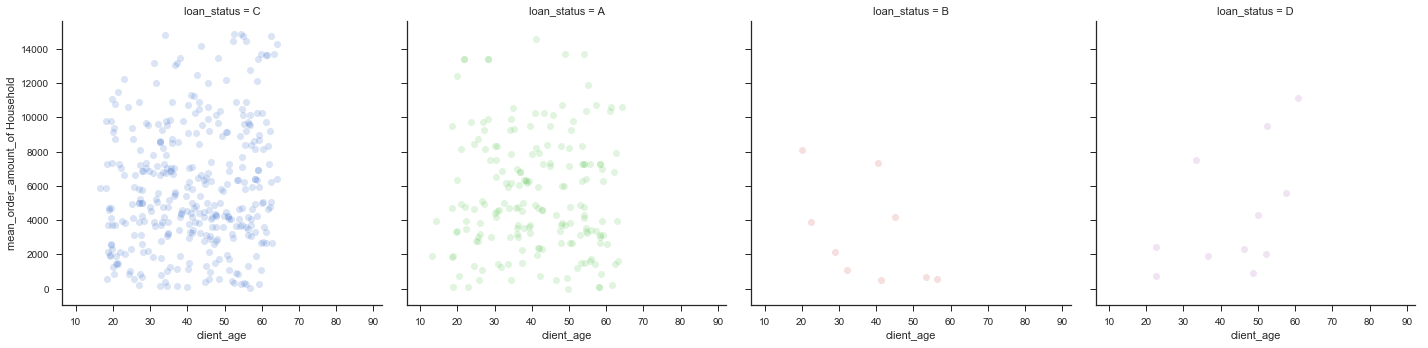

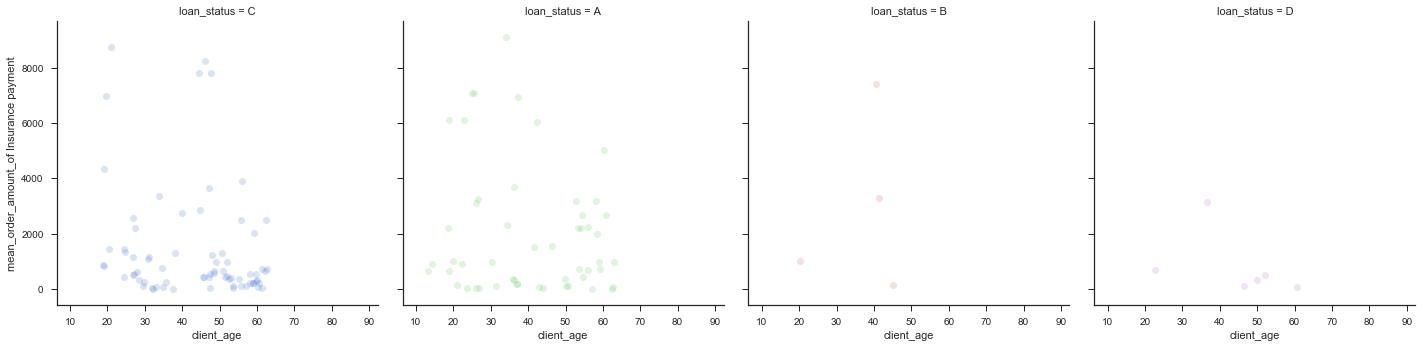

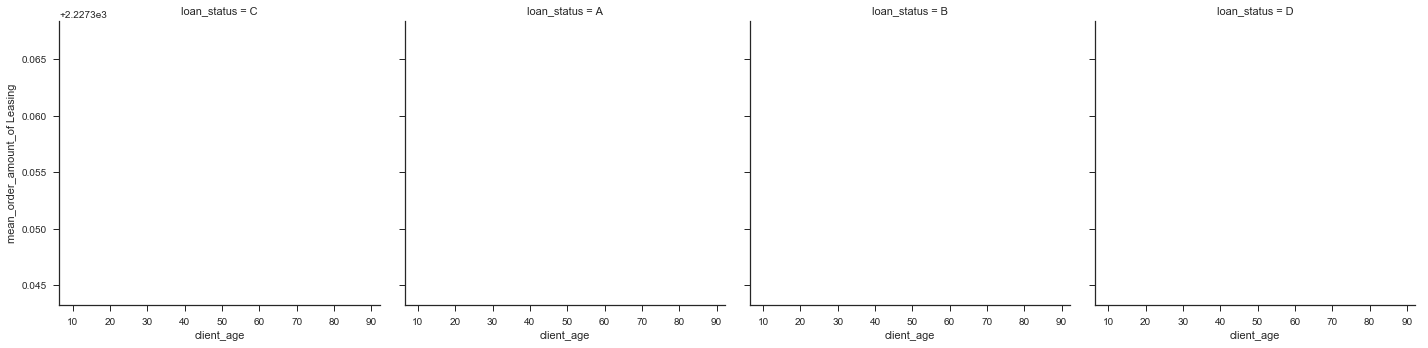

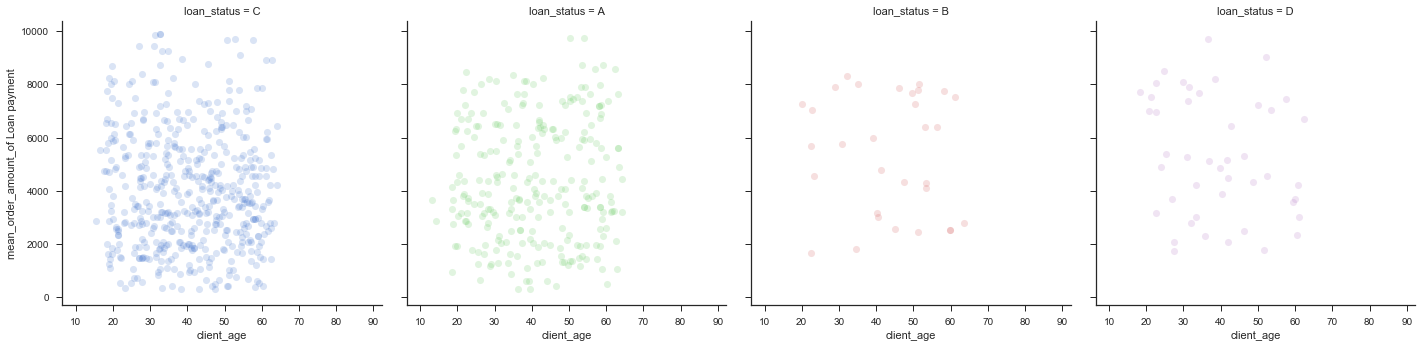

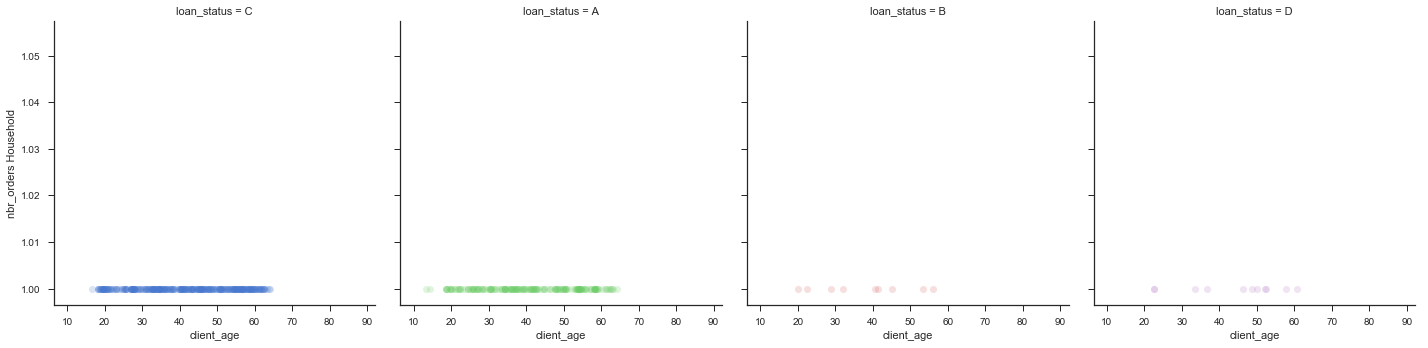

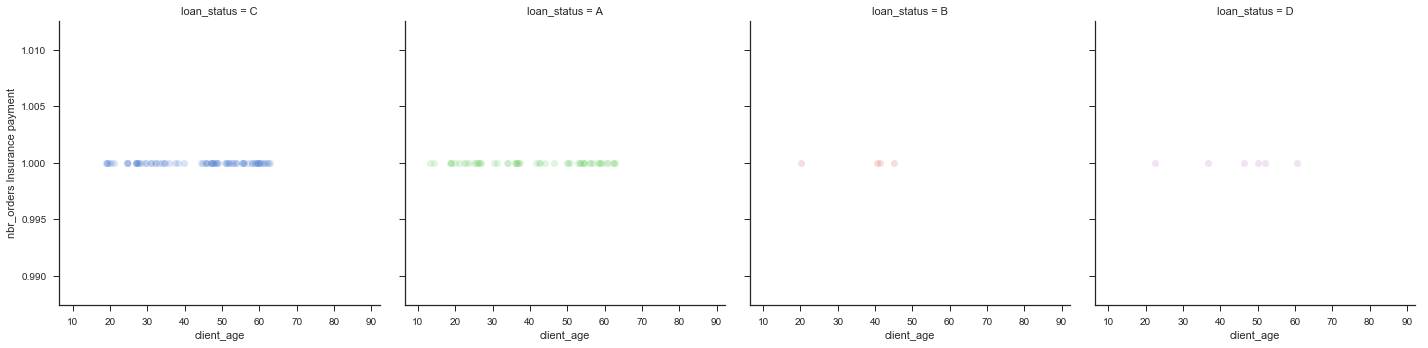

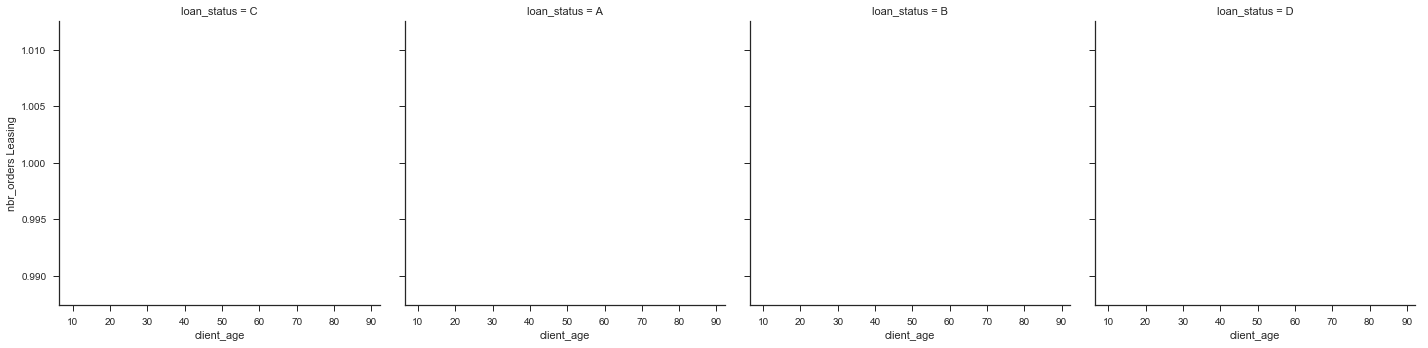

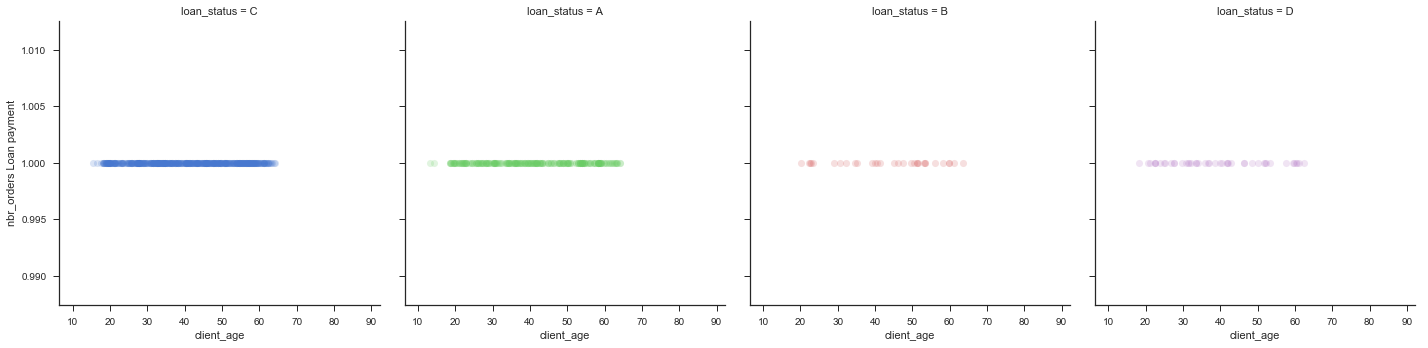

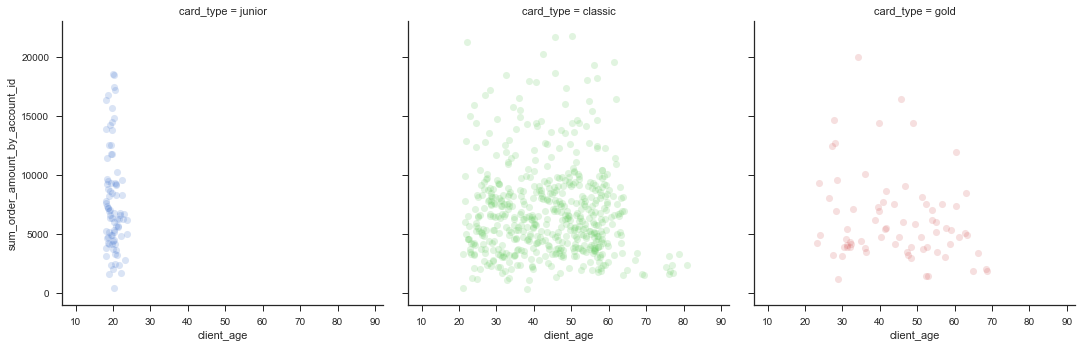

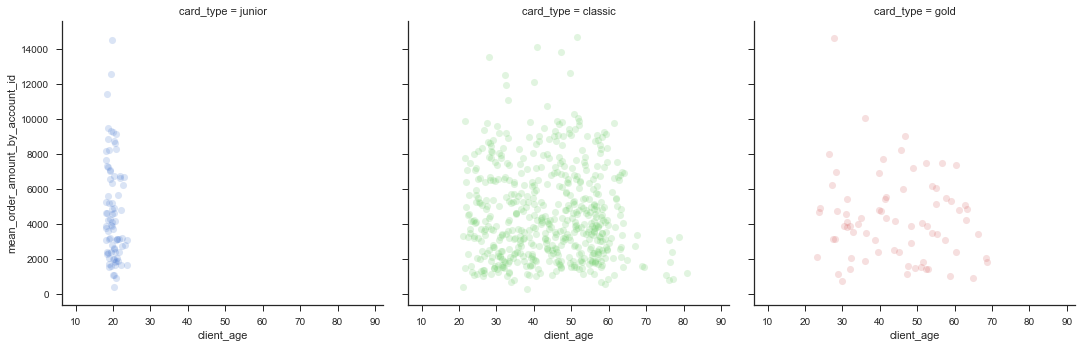

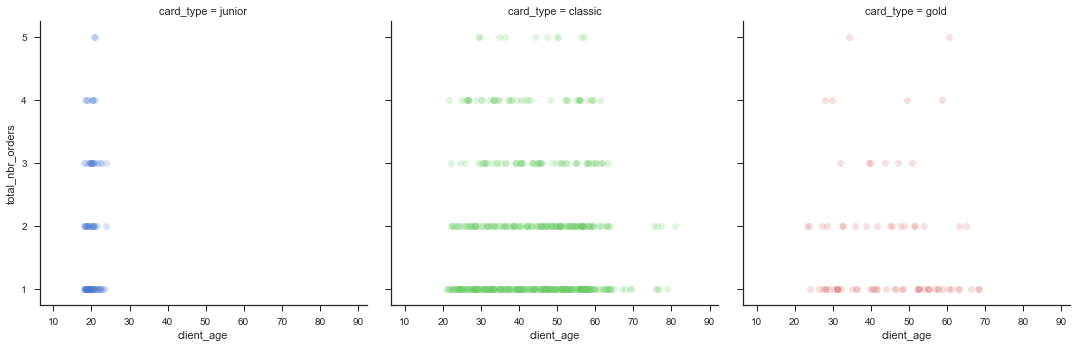

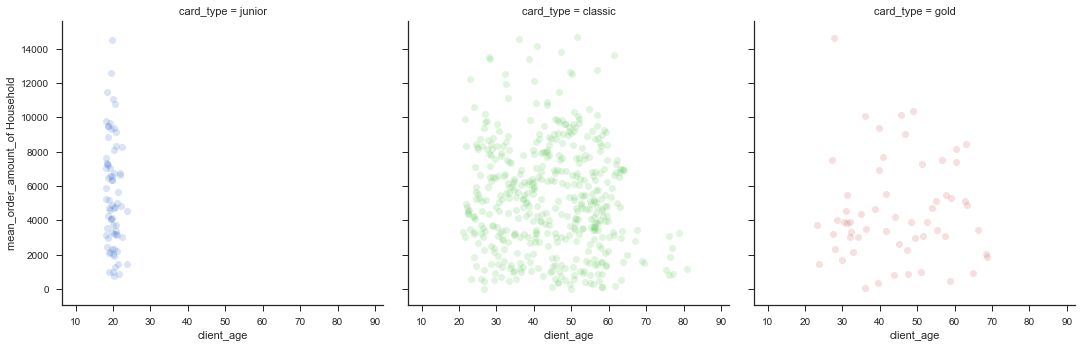

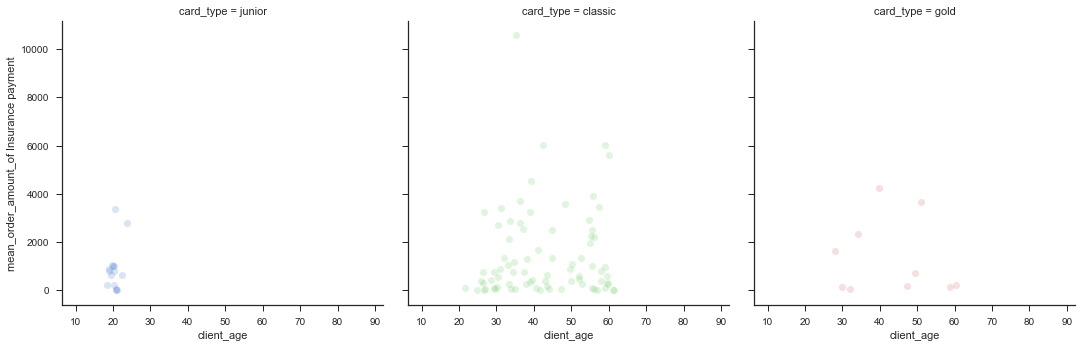

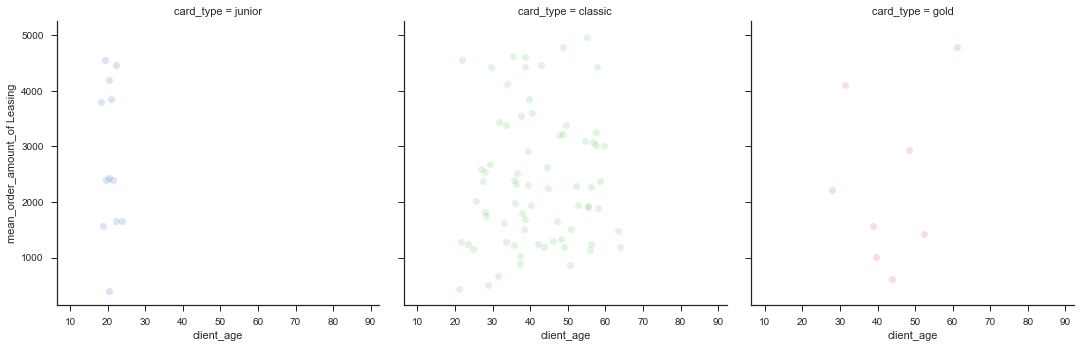

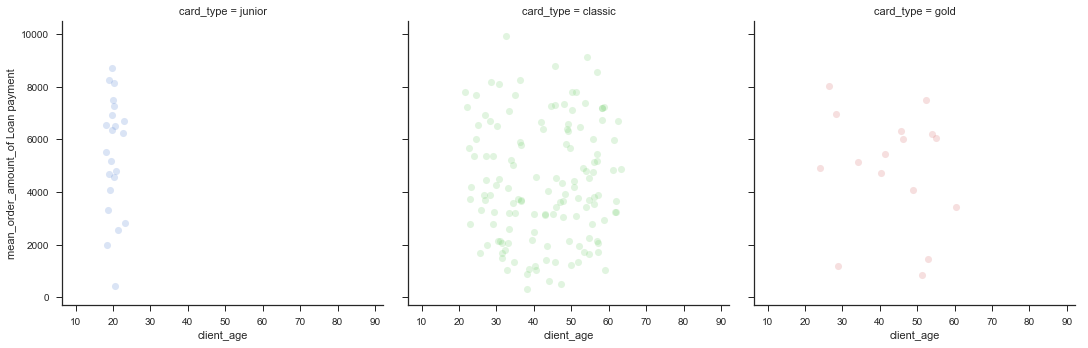

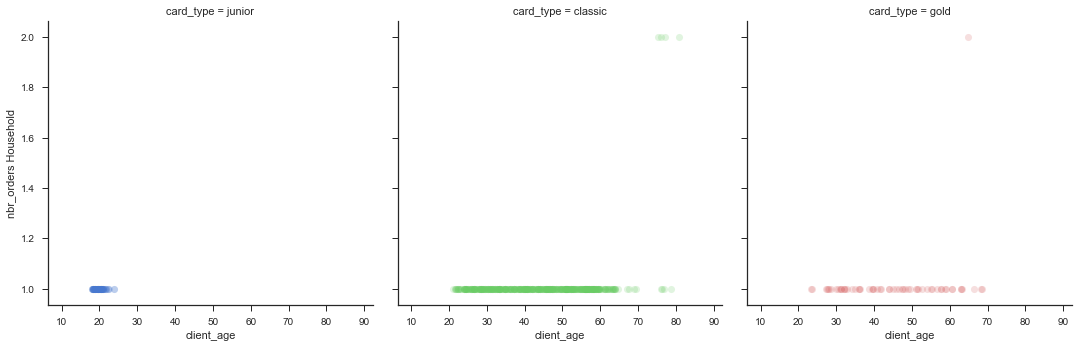

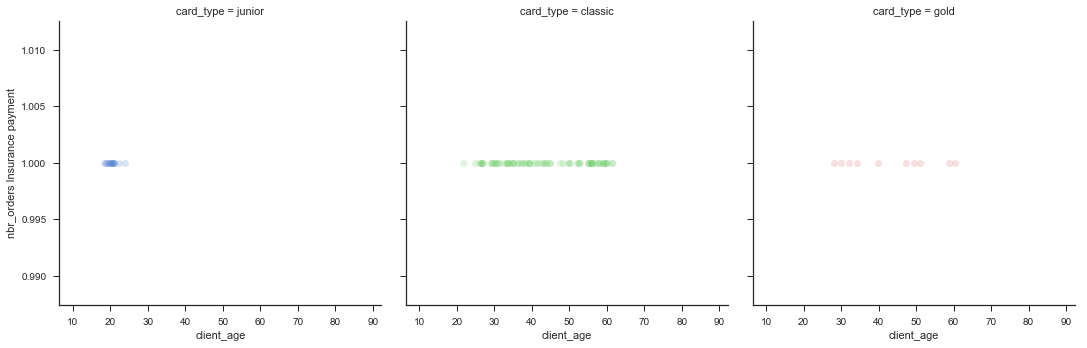

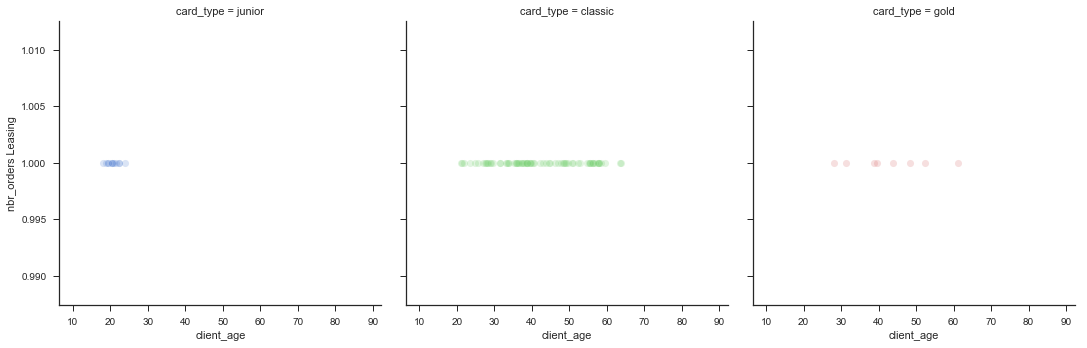

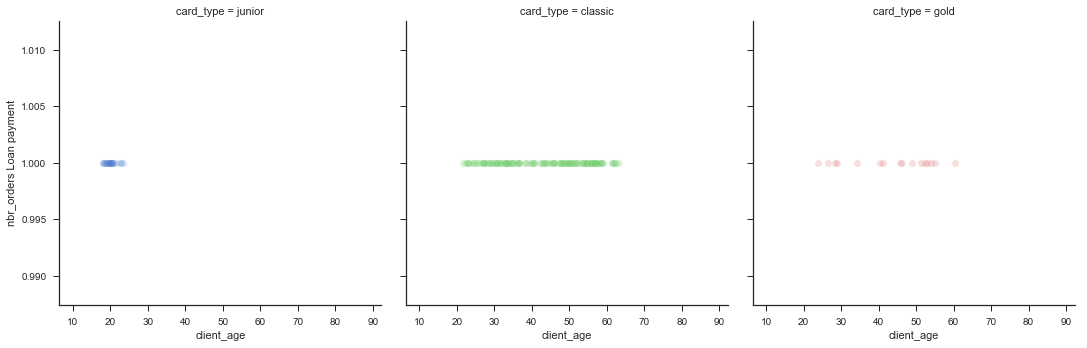

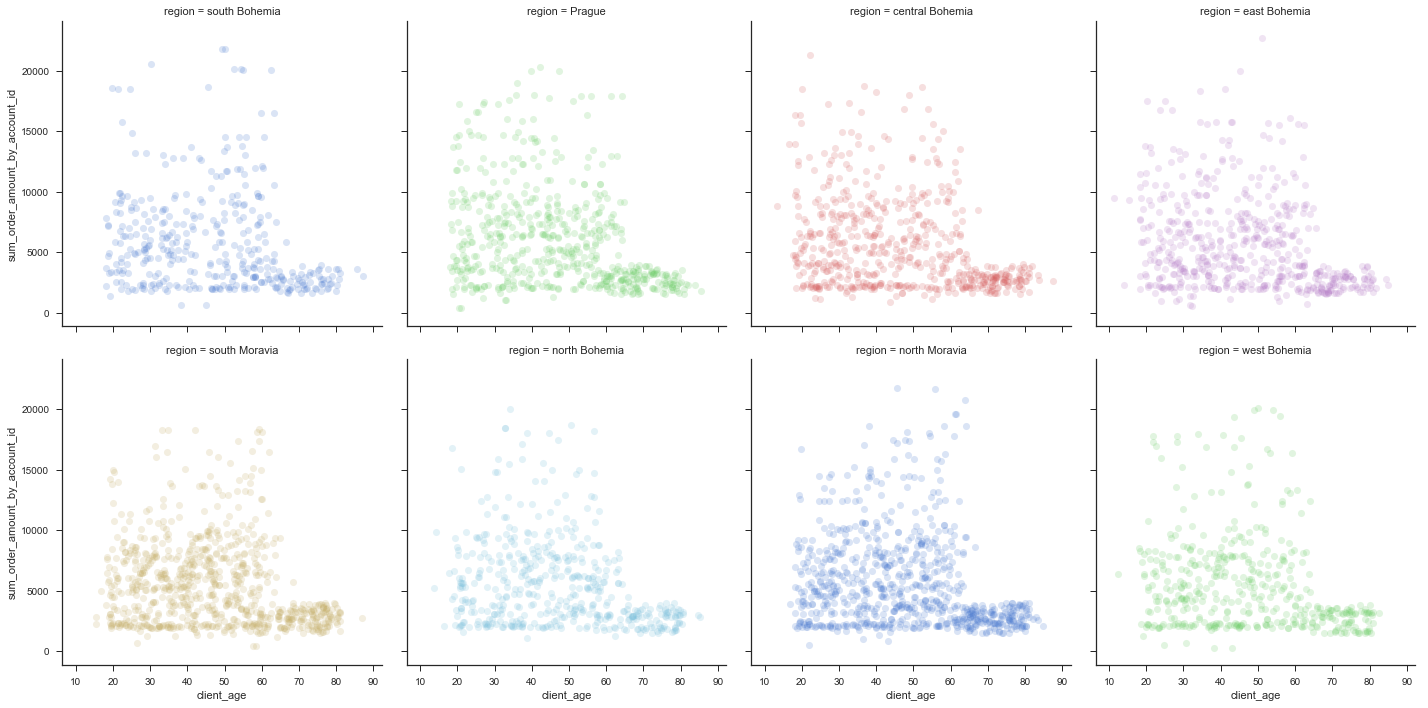

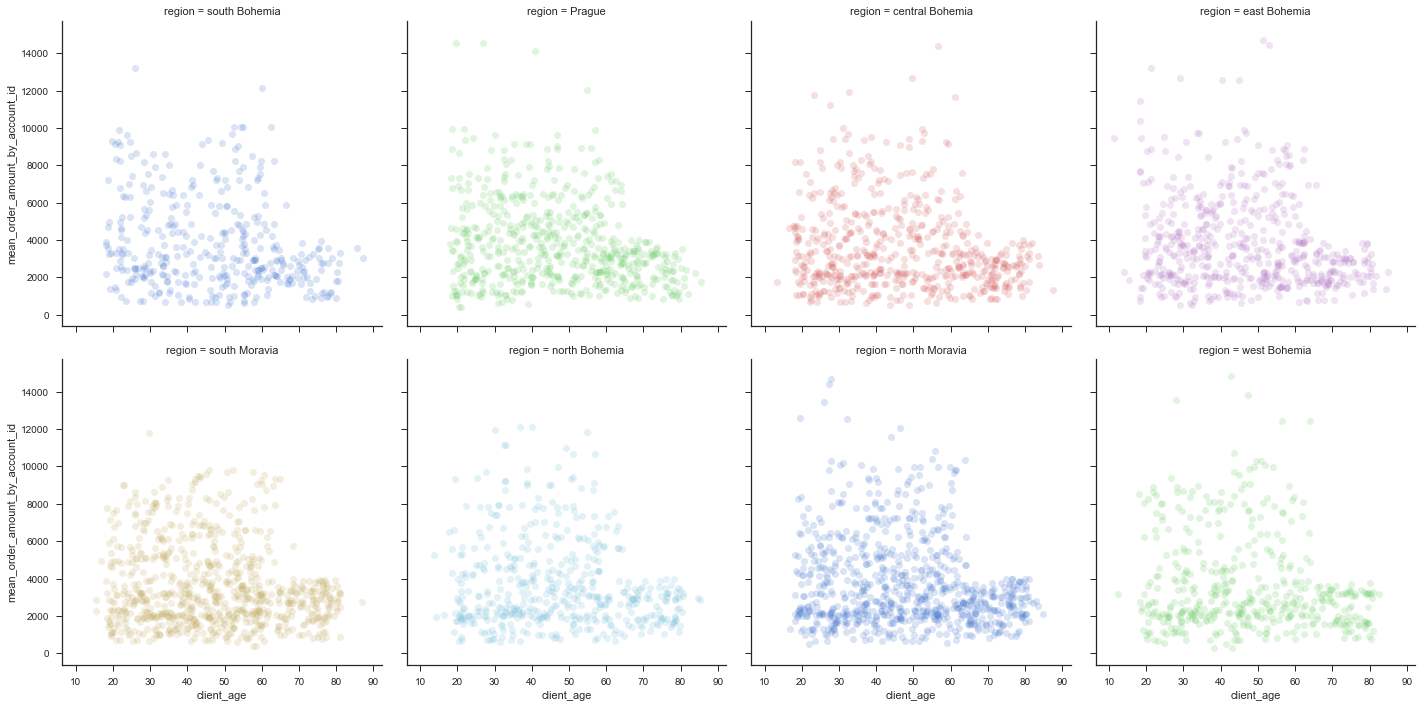

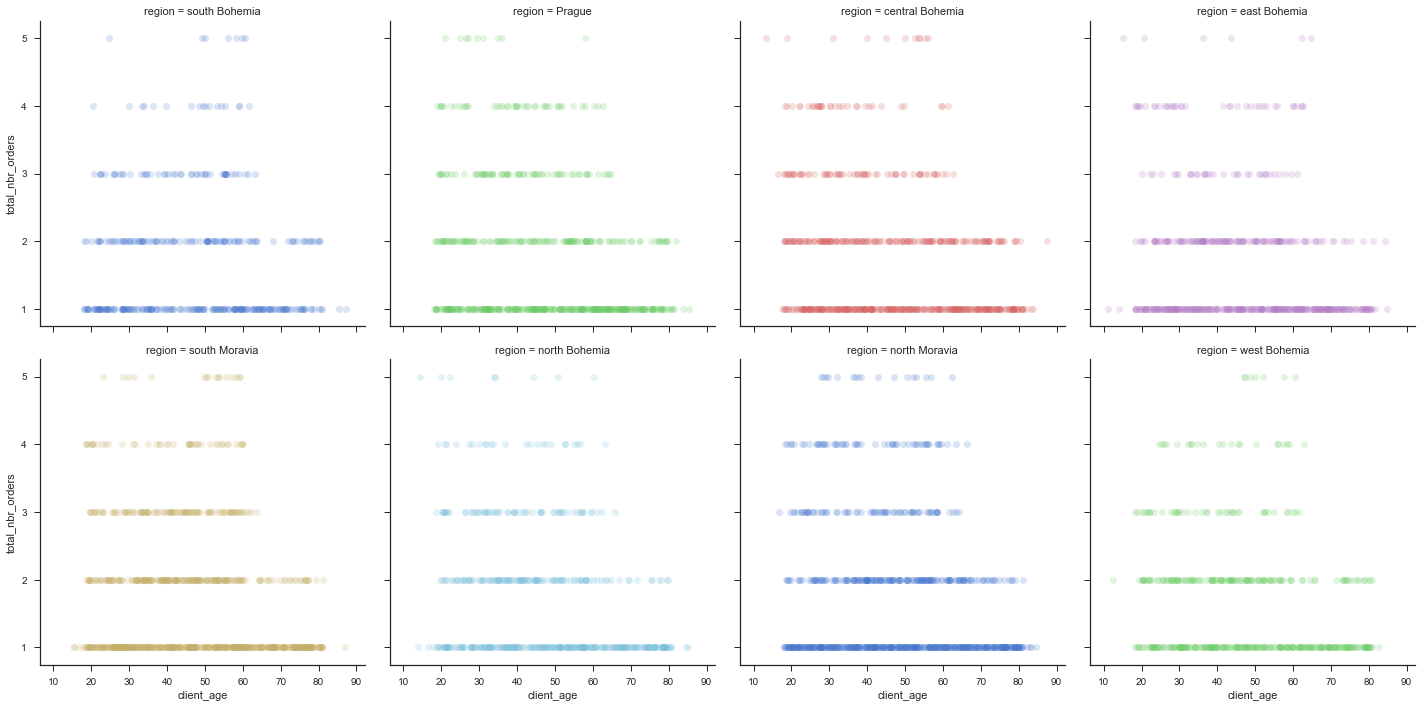

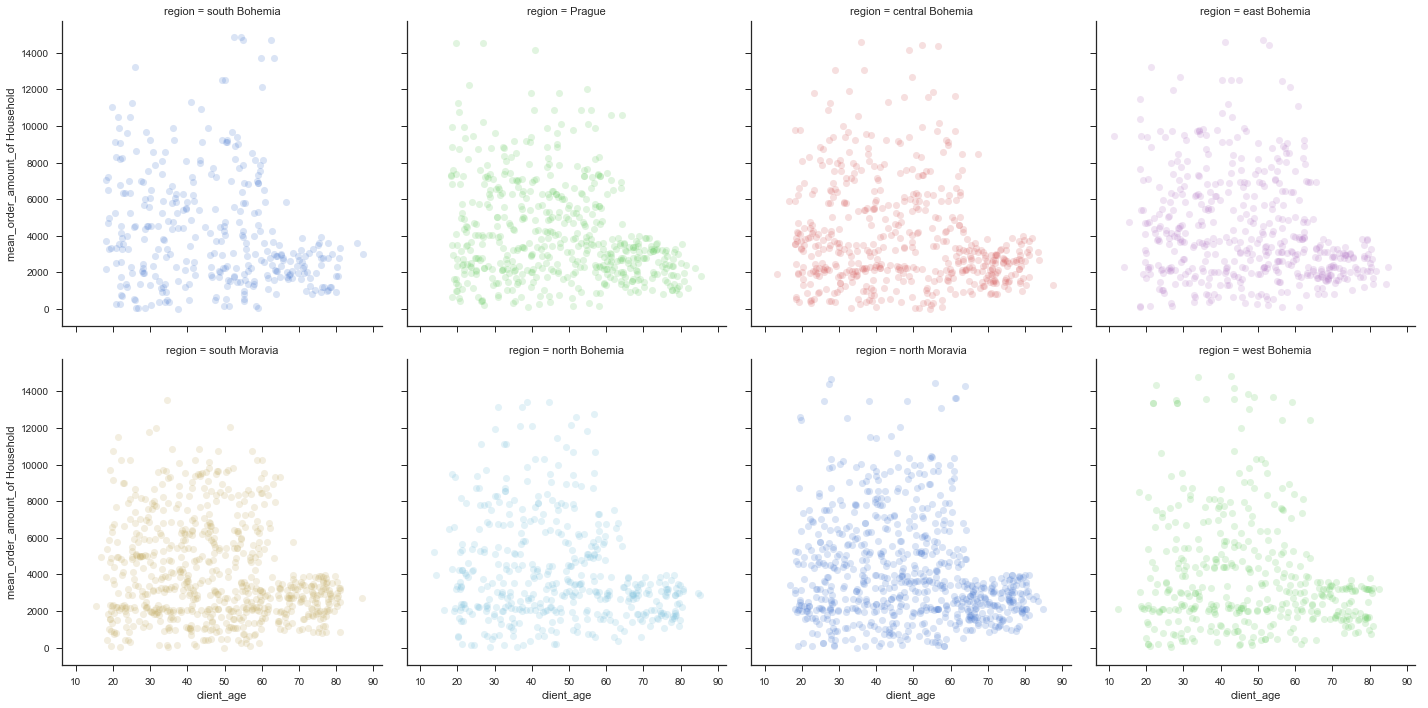

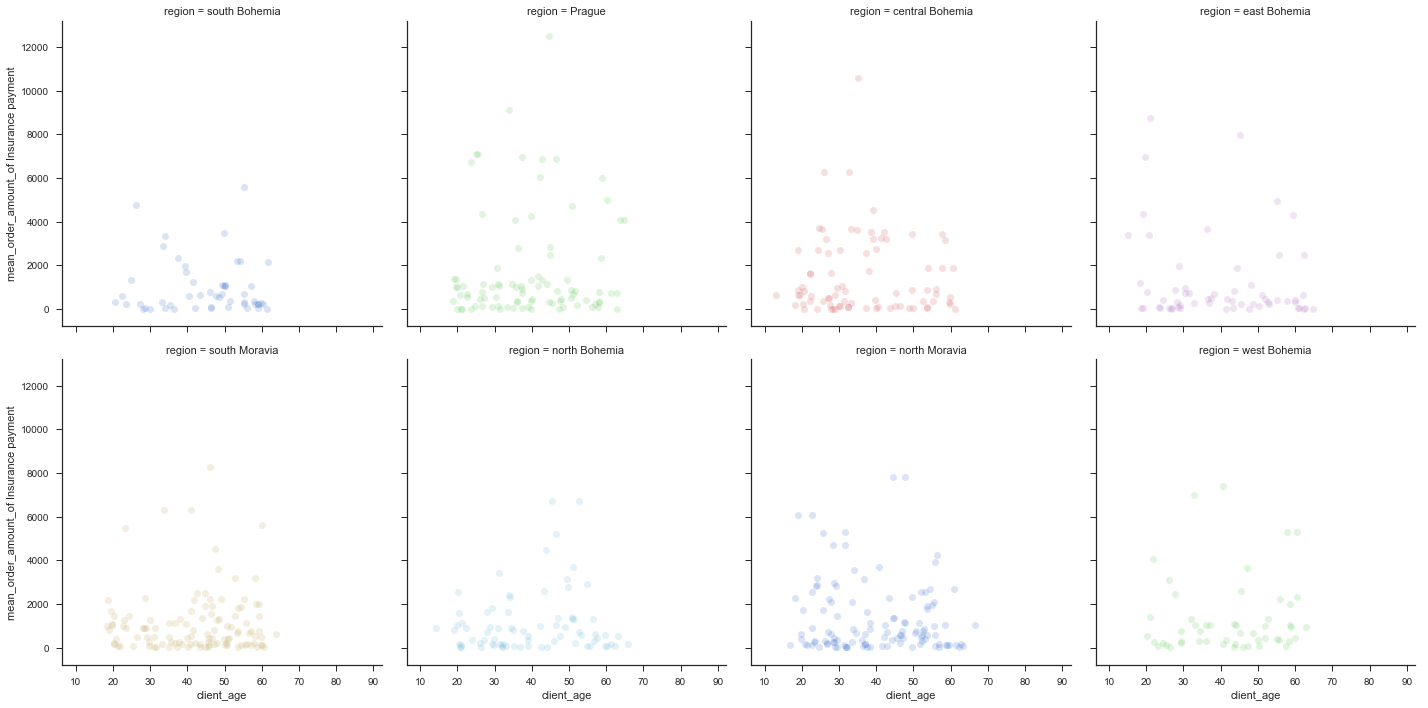

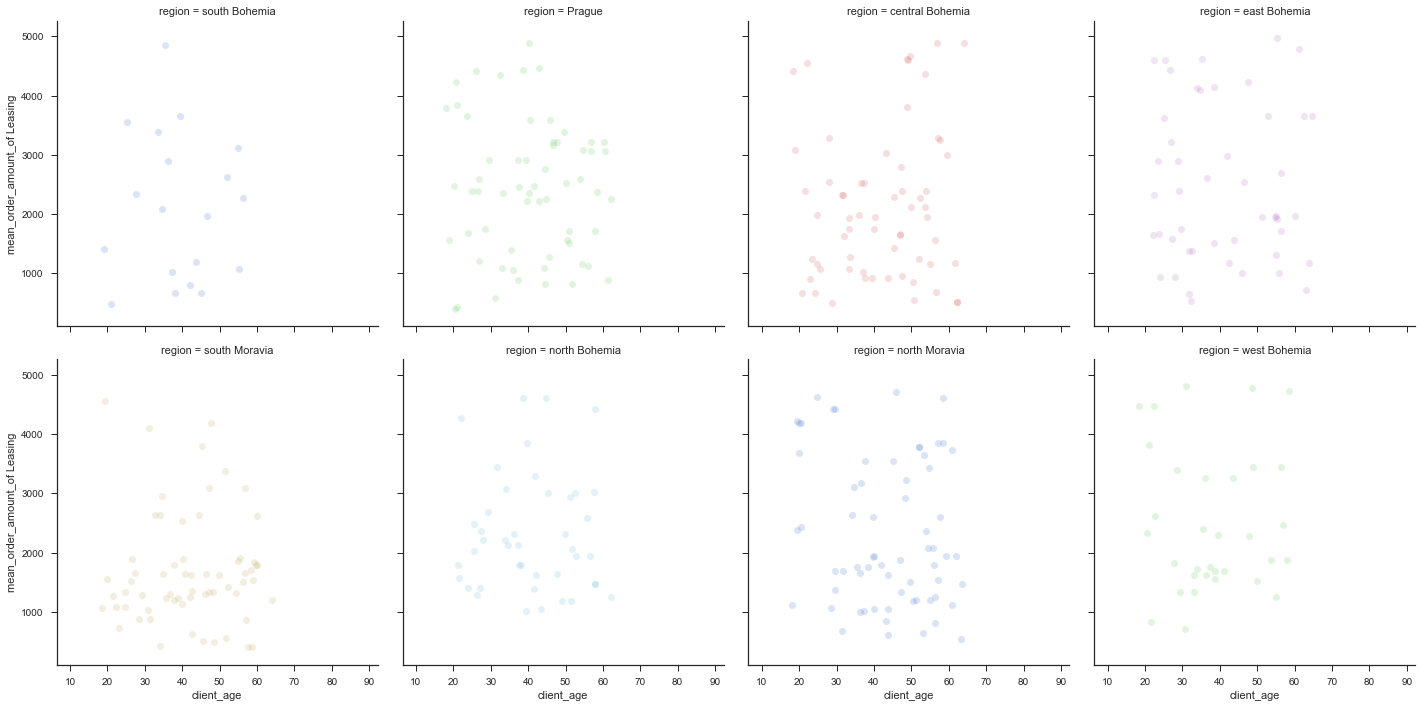

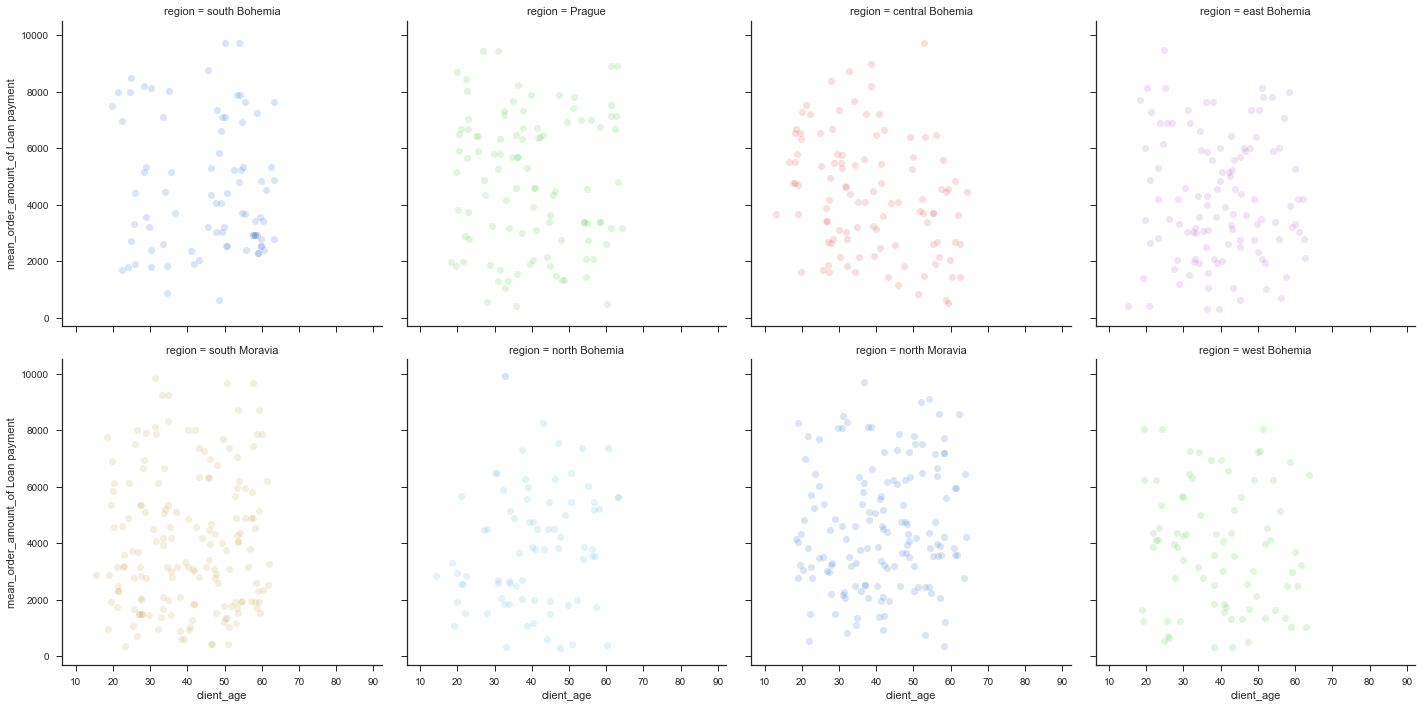

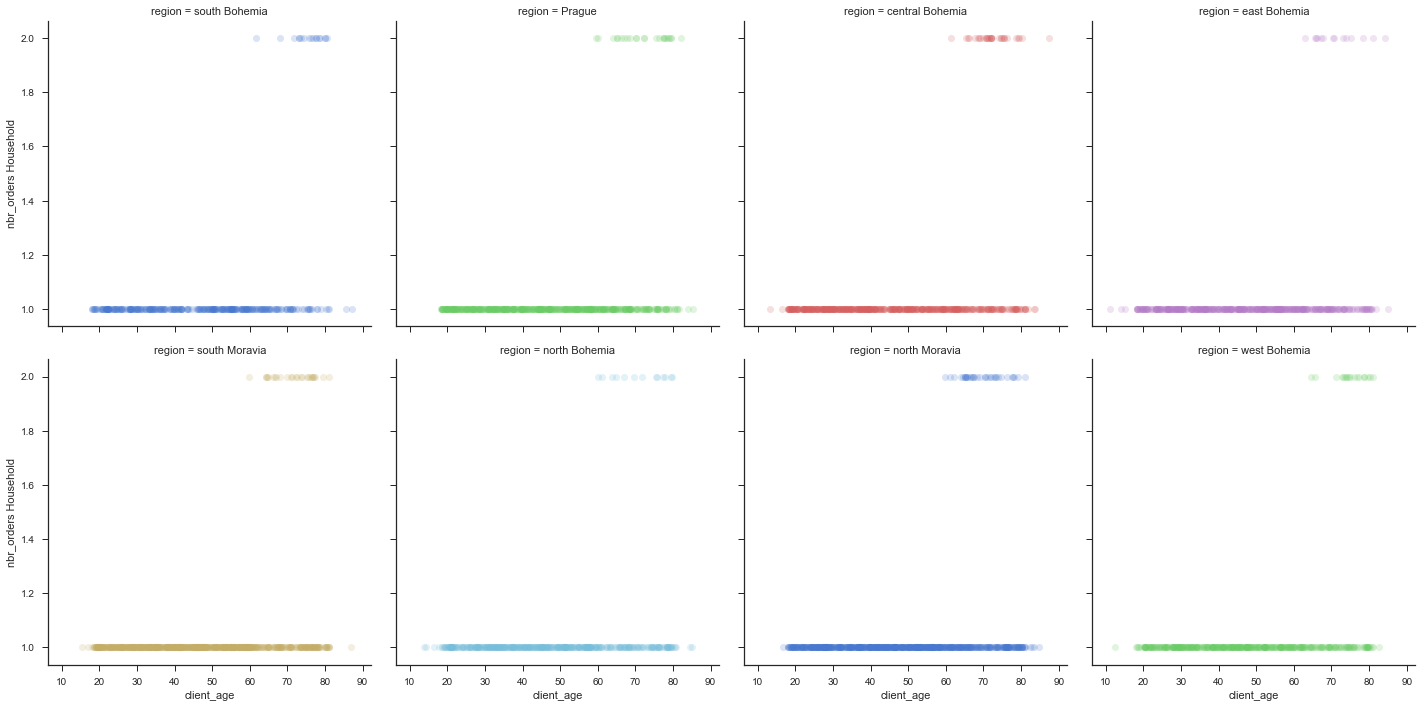

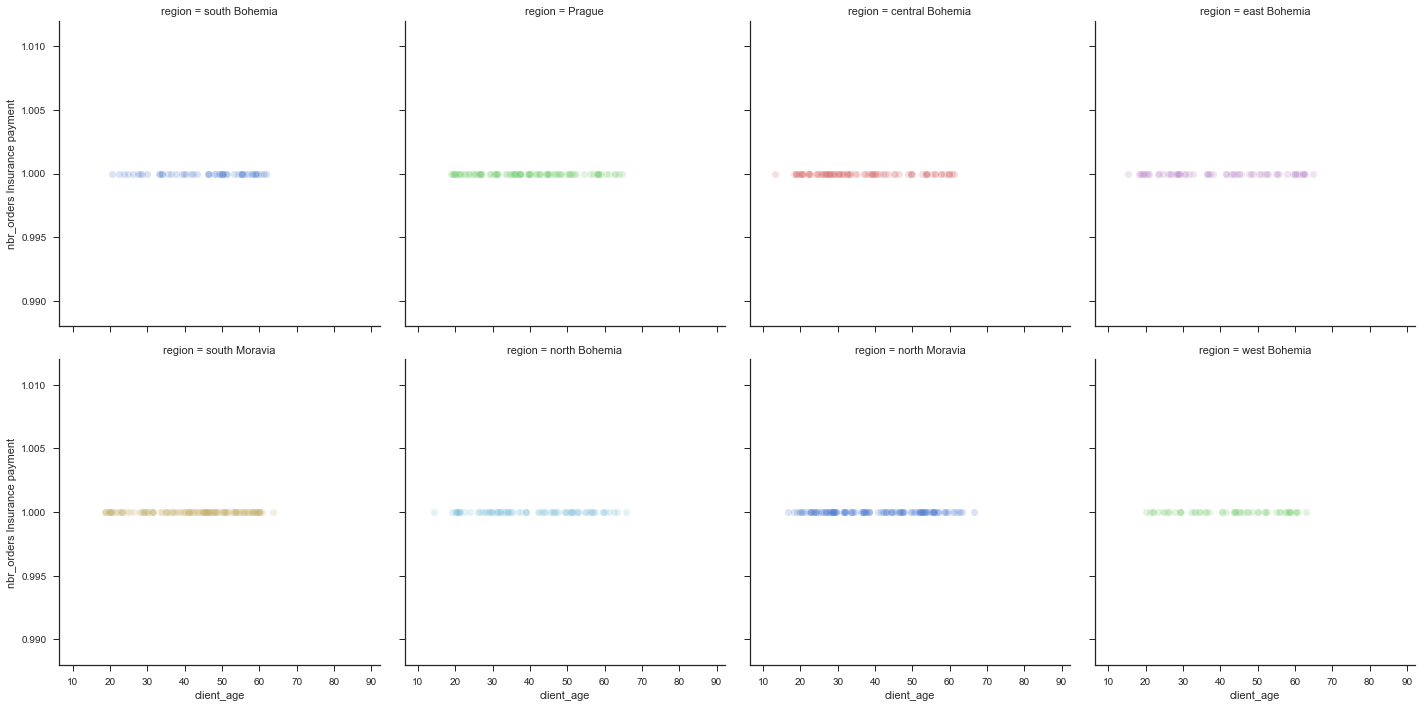

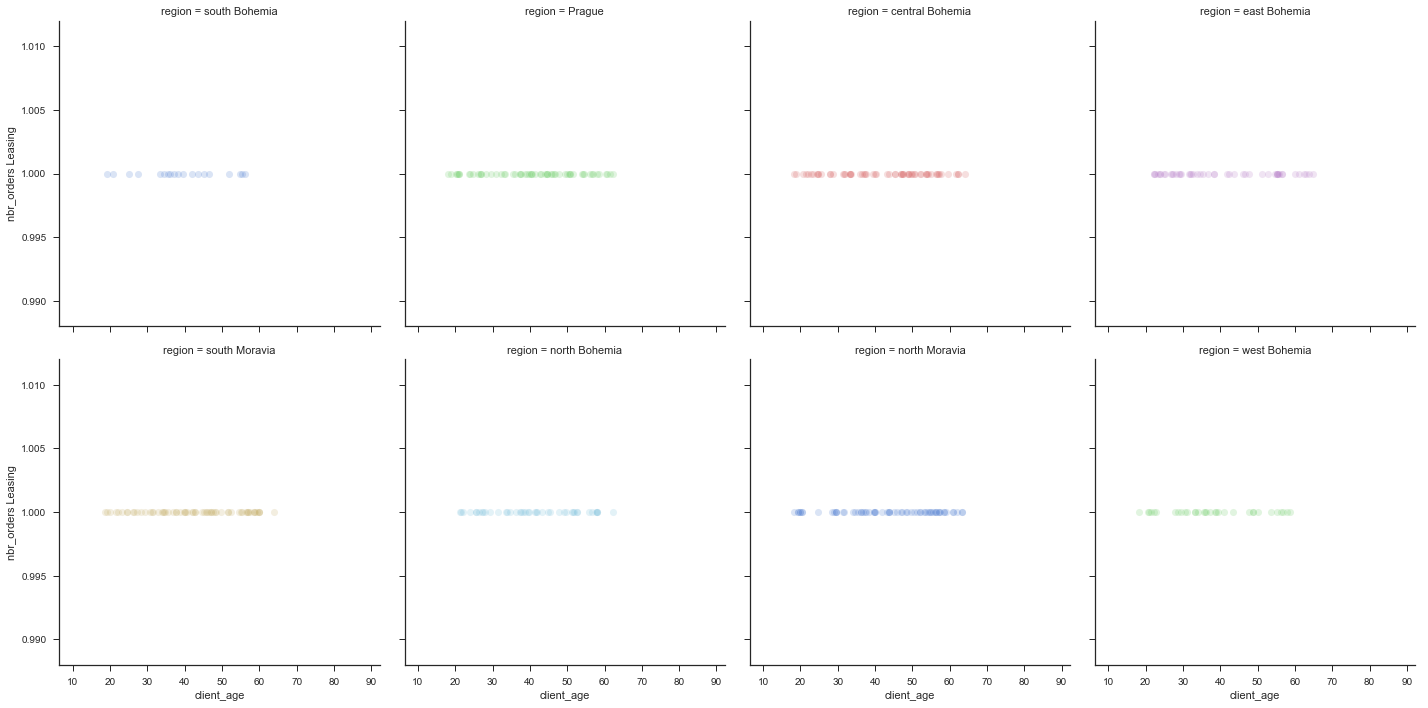

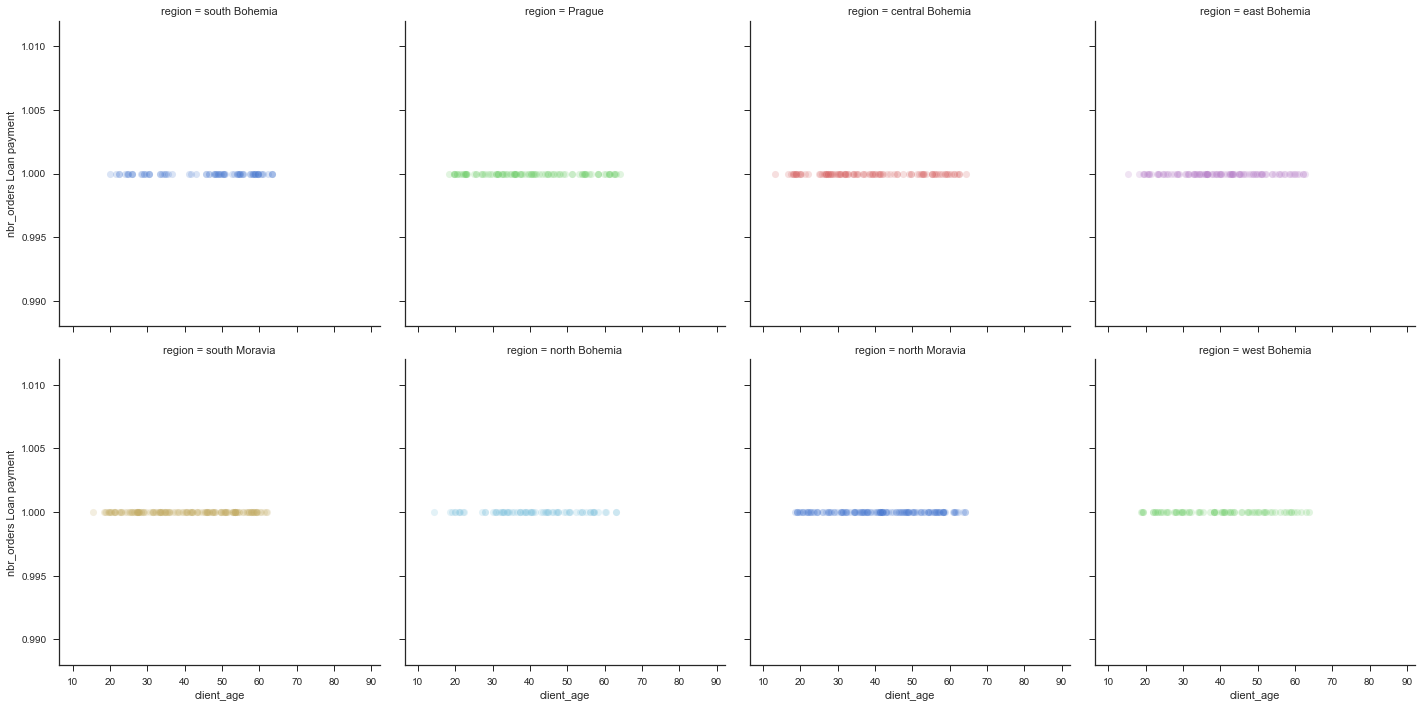

In [211]:
allcols=list(table)
sns.set(style="ticks")
cat_cols = ['client_gender', 'card_type', 'statement_freq', 'loan_status', 'card_type', 'region']
x_cols = ['client_age']
y_cols = [col for col in table.columns if 'order' in col]
for cat_col in cat_cols:
    for x_col in x_cols:
        for y_col in y_cols:
            g = sns.lmplot(x=x_col, y=y_col,col=cat_col, hue=cat_col, data=table,
                       col_wrap=4, ci=None, palette="muted",fit_reg=False,
                       scatter_kws={"s": 50, "alpha": 0.2})
            

In [104]:
f = plt.figure(1)
y = table['mean_trans_amount_of_Unknown_Transaction_Type']
x = table['nbr_trans_Unknown_Transaction_Type']
#y_pos = np.arange(len(x))
plt.xlim(1, 54)
plt.bar(x, y, color=(0.2, 0.4, 0.6, 0.8))
# Custom Axis title
plt.xlabel('Number of Unknown transactions', fontweight='bold', color = 'green', fontsize='10', horizontalalignment='center')
plt.ylabel('Average Transaction Amount', fontweight='bold', color = 'red', fontsize='10', horizontalalignment='center')
plt.title('Unknown Transaction Frequency')
plt.show()


KeyError: 'mean_trans_amount_of_Unknown_Transaction_Type'

C:\Users\Bhargava\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ValueError: cannot convert float NaN to integer

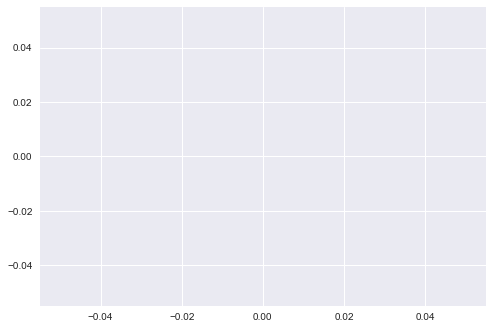

In [107]:
sns.distplot(table['1yr_mean_trans_amount_by_account_id'])
sns.plt.show()
plt.xlabel('Mean Transaction amount in last 1 year', fontweight='bold', color = 'green', fontsize='10', horizontalalignment='center')
plt.title('Average Transaction Amount in the last 1 year')
plt.show()

In [128]:
table_sorted= table.sort_values(by=['3yr_mean_trans_amount_by_account_id'])
table_sorted.head()

client_id_x  client_district_id  birth_year  age  age_group  \
5220         2399                  42        1943   56         56   
4466         3045                  10        1950   49         49   
3827          436                   2        1955   44         44   
3426          730                  63        1973   26         26   
3425          729                  63        1969   30         30   

      birth_month gender  client_age client_gender  disp_id      ...       \
5220            5      F   55.706849             F     2399      ...        
4466            3      F   48.824658             F     3045      ...        
3827            6      M   43.578082             M      436      ...        
3426            8      M   25.400000             M      730      ...        
3425            3      F   29.813699             F      729      ...        

      2000_to_9999 greater_than0000  num_cities  ratio_urban  avg_salary  \
5220             5                2           7         59.1        8388   
4466             4                3           5         46.7       10124   
3827             6                2           5         46.7        8507   
3426             5                1           5         50.5        8288   
3425             5                1           5         50.5        8288   

      unemp_rate_95  unemp_rate_96  enterpreneurs_per000  num_crimes95  \
5220           2.41           2.94                    87          1658   
4466           0.56           0.54                   141          3810   
3827           1.67           1.85                   132          2159   
3426           3.79           4.52                   110          1562   
3425           3.79           4.52                   110          1562   

      num_crimes96  
5220          1668  
4466          4316  
3827          2674  
3426          1460  
3425          1460  

[5 rows x 85 columns]

In [178]:
table.keys()

Index(['client_id_x', 'client_district_id', 'client_age', 'client_gender',
       'disp_id', 'account_id_x', 'type_x',
       'alltime_sum_trans_amount_by_account_id',
       'alltime_mean_trans_amount_by_account_id', 'alltime_total_nbr_trans',
       'mean_trans_amount_of Household',
       'mean_trans_amount_of Insurance payment',
       'mean_trans_amount_of Interest credited',
       'mean_trans_amount_of Loan payment',
       'mean_trans_amount_of Old-age pension',
       'mean_trans_amount_of Payment for statement',
       'mean_trans_amount_of Sanction interest if negative balance',
       'mean_trans_amount_of Unknown_Transaction_Type_x',
       'nbr_trans Household', 'nbr_trans Insurance payment',
       'nbr_trans Interest credited', 'nbr_trans Loan payment',
       'nbr_trans Old-age pension', 'nbr_trans Payment for statement',
       'nbr_trans Sanction interest if negative balance',
       'nbr_trans Unknown_Transaction_Type_x', 'mean_trans_amount_of Credit',
       'mean_

In [105]:
table[pd.to_numeric(table['1yr_sum_trans_amount_by_account_id'], errors='coerce').notnull()]

client_id_x  client_district_id  birth_year  age  age_group  \
0               1                  18        1970   29         29   
1             420                  18        1978   21         21   
2             499                  18        1935   64         64   
3             519                  18        1980   19         19   
4             682                  18        1979   20         20   
5            1140                  18        1946   53         53   
6            1169                  18        1941   58         58   
7            1259                  18        1966   33         33   
8            1376                  18        1958   41         41   
9            1377                  18        1951   48         48   
10           1382                  18        1979   20         20   
11           1410                  18        1944   55         55   
12           1411                  18        1939   60         60   
13           1574                  18        1979   20         20   
14           1883                  18        1961   38         38   
15           1978                  18        1952   47         47   
16           2103                  18        1944   55         55   
17           2139                  18        1932   67         67   
18           2140                  18        1926   73         73   
19           2176                  18        1946   53         53   
20           2329                  18        1973   26         26   
21           2517                  18        1924   75         75   
22           2518                  18        1921   78         78   
23           2631                  18        1970   29         29   
24           2632                  18        1963   36         36   
25           2794                  18        1965   34         34   
26           2795                  18        1968   31         31   
27           2841                  18        1973   26         26   
28           2900                  18        1923   76         76   
29           2924                  18        1941   58         58   
...           ...                 ...         ...  ...        ...   
5339         3689                   9        1979   20         20   
5340         3697                   9        1954   45         45   
5341         4081                   9        1978   21         21   
5342         4141                   9        1970   29         29   
5343         4146                   9        1955   44         44   
5344         4217                   9        1951   48         48   
5345         4235                   9        1975   24         24   
5346         4248                   9        1975   24         24   
5347         4547                   9        1943   56         56   
5348         4560                   9        1963   36         36   
5349         4585                   9        1948   51         51   
5350         4586                   9        1951   48         48   
5351         4665                   9        1926   73         73   
5352         4666                   9        1928   71         71   
5353         4781                   9        1966   33         33   
5354         4928                   9        1976   23         23   
5355         5164                   9        1971   28         28   
5356         5461                   9        1968   31         31   
5357         5462                   9        1963   36         36   
5358         5521                   9        1973   26         26   
5359         5574                   9        1970   29         29   
5360         6749                   9        1943   56         56   
5361         6750                   9        1946   53         53   
5362         9313                   9        1960   39         39   
5363         9872                   9        1967   32         32   
5364         9930                   9        1972   27         27   
5365

In [106]:
table['1yr_sum_trans_amount_by_account_id'] = table['1yr_sum_trans_amount_by_account_id'].fillna(0)

C:\Users\Bhargava\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\Bhargava\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning:

invalid value encountered in reduce

C:\Users\Bhargava\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning:

invalid value encountered in reduce



ValueError: cannot convert float NaN to integer

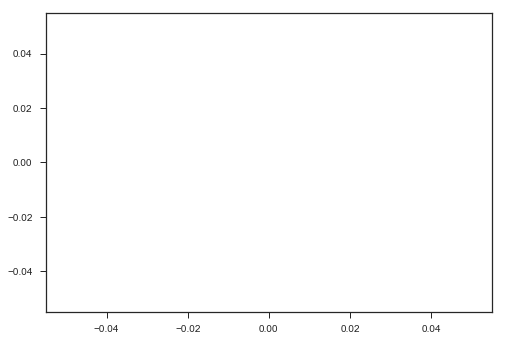

In [234]:
sns.distplot(table['1yr_mean_trans_amount_by_account_id'])
sns.plt.show()
plt.xlabel('Mean Transaction amount in last 1 year', fontweight='bold', color = 'green', fontsize='10', horizontalalignment='center')
plt.title('Average Transaction Amount in the last 1 year')
plt.show()

In [129]:
table_sorted['3yr_mean_trans_amount_by_account_id'][1100]

2240.194705882352

In [154]:
d2 = pd.DataFrame(columns = ['label'],index = range(5369))
for i in range(len(table_sorted['3yr_mean_trans_amount_by_account_id'])):
    if table_sorted['3yr_mean_trans_amount_by_account_id'][i]>2240:
        d2['label'][i] = 1
    else:
        d2['label'][i] = 0

temp = pd.concat([table_sorted,d2],axis = 1)

In [157]:
temp.describe()

client_id_x  client_district_id   birth_year          age  \
count   5369.000000         5369.000000  5369.000000  5369.000000   
mean    3359.011920           37.310114  1953.198361    45.801639   
std     2832.911984           25.043690    17.282283    17.282283   
min        1.000000            1.000000  1911.000000    12.000000   
25%     1418.000000           14.000000  1940.000000    31.000000   
50%     2839.000000           38.000000  1954.000000    45.000000   
75%     4257.000000           60.000000  1968.000000    59.000000   
max    13998.000000           77.000000  1987.000000    88.000000   

         age_group  birth_month   client_age       disp_id  account_id_x  \
count  5369.000000  5369.000000  5369.000000   5369.000000   5369.000000   
mean     45.801639     6.521885    45.333158   3337.097970   2767.496927   
std      17.282283     3.432381    17.293540   2770.418826   2307.843630   
min      12.000000     1.000000    11.271233      1.000000      1.000000   
25%      31.000000     4.000000    30.583562   1418.000000   1178.000000   
50%      45.000000     7.000000    44.687671   2839.000000   2349.000000   
75%      59.000000     9.000000    58.139726   4257.000000   3526.000000   
max      88.000000    12.000000    87.427397  13690.000000  11382.000000   

       alltime_sum_trans_amount_by_account_id      ...       2000_to_9999  \
count                            5.359000e+03      ...        5369.000000   
mean                             1.383659e+06      ...           5.483144   
std                              1.335607e+06      ...           4.369373   
min                              2.940000e+04      ...           0.000000   
25%                              4.210149e+05      ...           2.000000   
50%                              8.782675e+05      ...           5.000000   
75%                              1.941576e+06      ...           7.000000   
max                              7.619102e+06      ...          20.000000   

       greater_than0000   num_cities  ratio_urban    avg_salary  \
count       5369.000000  5369.000000  5369.000000   5369.000000   
mean           1.709071     5.517974    69.240045   9510.758614   
std            1.075535     2.940686    19.896870   1330.686689   
min            0.000000     1.000000    33.900000   8110.000000   
25%            1.000000     4.000000    52.700000   8547.000000   
50%            1.000000     6.000000    63.100000   8980.000000   
75%            2.000000     8.000000    85.600000   9897.000000   
max            5.000000    11.000000   100.000000  12541.000000   

       unemp_rate_95  unemp_rate_96  enterpreneurs_per000  num_crimes95  \
count    5369.000000    5369.000000           5369.000000   5369.000000   
mean        2.821481       3.490942            121.191097  14650.256100   
std         1.882352       2.134924             23.106521  26985.700134   
min        -1.000000       0.430000             81.000000     -1.000000   
25%         1.510000       1.960000            105.000000   2159.000000   
50%         2.650000       3.470000            116.000000   3729.000000   
75%         3.850000       4.790000            131.000000   6604.000000   
max         7.340000       9.400000            167.000000  85677.000000   

       num_crimes96  
count   5369.000000  
mean   16352.240082  
std    31330.146616  
min      888.000000  
25%     2252.000000  
50%     3839.000000  
75%     6295.000000  
max    99107.000000  

[8 rows x 76 columns]

In [301]:
temp1 = temp.drop(['unemp_rate_95','unemp_rate_96','enterpreneurs_per000','num_crimes95','num_crimes96','total_inhabitants','type_x','region','district_name','type_y','statement_freq','loan_status','client_gender','gender','card_type'],axis=1)

In [185]:
final = temp.drop(['label'],axis = 1)

In [160]:
from pandas.tools.plotting import scatter_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint


C:\Users\Bhargava\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import f1_score


In [281]:
def reject_outliers(data):
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
    lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
    print(lower_whisker,upper_whisker)
    filtered= [e for e in (data) if (lower_whisker < e < upper_whisker)]
    return filtered

In [326]:
temp2 = temp1.fillna(method='ffill', axis=0).fillna(0)

In [340]:
train_set, test_set = train_test_split(temp2, test_size=0.50, random_state=42)

In [341]:
X_train_set=train_set.drop(['label'],axis=1)

In [342]:
Y_train_set=train_set[['label']]

In [343]:
X_test_set=test_set.drop(['label'],axis=1)

In [344]:
Y_test_set=test_set[['label']]

In [345]:
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

In [346]:
logreg.fit(X_train_set, Y_train_set)

C:\Users\Bhargava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [347]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


In [348]:
logreg.score(X_train_set, Y_train_set)

0.9463487332339792

In [349]:
logreg.score(X_test_set, Y_test_set)

0.9381750465549348

In [350]:
clf = RandomForestClassifier(n_jobs=2, random_state=0,n_estimators=15,max_depth=10,min_samples_leaf=5,max_features=.8,verbose=1)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train_set, np.ravel(Y_train_set))

[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=0.8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=2, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

In [351]:
clf.score(X_train_set, Y_train_set)

[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished


0.9996274217585693

In [352]:
clf.score(X_test_set, Y_test_set)

[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished


0.9992551210428305

In [354]:
y_pred=clf.predict(X_test_set)

[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished


In [355]:
df_confusion = pd.crosstab(np.ravel(Y_test_set), y_pred, rownames=['Actual'], colnames=['Predicted'])

In [356]:
df_confusion

Predicted    0     1
Actual              
0          687     0
1            2  1996

In [357]:
clf = GaussianNB()

In [358]:
clf.fit(X_train_set, np.ravel(Y_train_set))

GaussianNB(priors=None)

In [359]:
clf.score(X_train_set, Y_train_set)

0.8599105812220567

In [360]:
clf.score(X_test_set, Y_test_set)

0.8644320297951583

In [361]:
y_pred=clf.predict(X_test_set)

In [362]:
df_confusion = pd.crosstab(np.ravel(Y_test_set), y_pred, rownames=['Actual'], colnames=['Predicted'])

In [363]:
df_confusion

Predicted    0     1
Actual              
0          673    14
1          350  1648

In [365]:
temp1.describe()

client_id_x  client_district_id   birth_year          age  \
count   5369.000000         5369.000000  5369.000000  5369.000000   
mean    3359.011920           37.310114  1953.198361    45.801639   
std     2832.911984           25.043690    17.282283    17.282283   
min        1.000000            1.000000  1911.000000    12.000000   
25%     1418.000000           14.000000  1940.000000    31.000000   
50%     2839.000000           38.000000  1954.000000    45.000000   
75%     4257.000000           60.000000  1968.000000    59.000000   
max    13998.000000           77.000000  1987.000000    88.000000   

         age_group  birth_month   client_age       disp_id  account_id_x  \
count  5369.000000  5369.000000  5369.000000   5369.000000   5369.000000   
mean     45.801639     6.521885    45.333158   3337.097970   2767.496927   
std      17.282283     3.432381    17.293540   2770.418826   2307.843630   
min      12.000000     1.000000    11.271233      1.000000      1.000000   
25%      31.000000     4.000000    30.583562   1418.000000   1178.000000   
50%      45.000000     7.000000    44.687671   2839.000000   2349.000000   
75%      59.000000     9.000000    58.139726   4257.000000   3526.000000   
max      88.000000    12.000000    87.427397  13690.000000  11382.000000   

       alltime_sum_trans_amount_by_account_id  \
count                            5.359000e+03   
mean                             1.383659e+06   
std                              1.335607e+06   
min                              2.940000e+04   
25%                              4.210149e+05   
50%                              8.782675e+05   
75%                              1.941576e+06   
max                              7.619102e+06   

                        ...                     card_issued_date  district_id  \
count                   ...                           892.000000  5369.000000   
mean                    ...                          1722.221973    37.310114   
std                     ...                           402.533305    25.043690   
min                     ...                           310.000000     1.000000   
25%                     ...                          1485.500000    14.000000   
50%                     ...                          1831.000000    38.000000   
75%                     ...                          2042.250000    60.000000   
max                     ...                          2188.000000    77.000000   

       num_munipalities_less_499    500_to999  2000_to_9999  greater_than0000  \
count                5369.000000  5369.000000   5369.000000       5369.000000   
mean                   39.630844    20.739616      5.483144          1.709071   
std                    34.462701    15.190457      4.369373          1.075535   
min                     0.000000     0.000000      0.000000          0.000000   
25%                     8.000000    10.000000      2.000000          1.000000   
50%                    34.000000    21.000000      5.000000          1.000000   
75%                    65.000000    30.000000      7.000000          2.000000   
max                   151.000000    70.000000     20.000000          5.000000   

        num_cities  ratio_urban    avg_salary  \
count  5369.000000  5369.000000   5369.000000   
mean      5.517974    69.240045   9510.758614   
std       2.940686    19.896870   1330.686689   
min       1.000000    33.900000   8110.000000   
25%       4.000000    52.700000   8547.000000   
50%       6.000000    63.100000   8980.000000   
75%       8.000000    85.600000   9897.000000   
max      11.000000   100.000000  12541.000000   

       alltime_sum_trans_amount_by_account_id   
count                             5.359000e+03  
mean                              1.383659e+06  
std                               1.335607e+06  
min                               2.940000e+04  
25%                               4.210149e+05  
50%                               8.782675e+05  
75%           

In [366]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(40,40,8), random_state=1)

In [367]:
clf.fit(X_train_set, np.ravel(Y_train_set))

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40, 40, 8), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [368]:
precision_score(np.ravel(Y_test_set), y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)

0.9915764139590855

In [369]:
recall_score(np.ravel(Y_test_set), y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)

0.8248248248248248

In [370]:
f1_score(np.ravel(Y_test_set), y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)

0.9005464480874317

In [ ]:
import pickle
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [375]:
input_dim = X_train_set.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

NameError: name 'Input' is not defined

In [ ]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history
